In [1]:
import numpy as np
from astropy import table
import matplotlib.pyplot as plt
import csv
import matplotlib.colors as colours
import os

### Prepare the data for training 

In [2]:
# Access data file for model learning
filename = "/raid/users/heigerm/catalogues/sp_x_apogee_x_spspectra_rvtab.fits"

# Access the Bokyoung’s substructure
sub_filename = "/raid/DESI/spectra/sptab_spspectra_rvtab_substructure.fits"

In [3]:
from astropy.io import fits
from astropy.table import Table, vstack, Column
# sp data
HDUlist = fits.open(filename)

# substructure
sub_HDUlist = fits.open(sub_filename)

In [4]:
# Load the tables for parameters and sp normalized spectra
# DESI
sp_tab = Table(HDUlist['SPTAB'].data)   

# Substructure
sub_sp_tab = Table(sub_HDUlist['SPTAB'].data)  

# APOGEE
apogee_tab = Table(HDUlist['APOGEEDR17'].data) 

# DESI SP Spectra
spectra = Table(HDUlist['SPECTRA_SP'].data)

# Substructure spectra
sub_spectra = Table(sub_HDUlist['SPECTRA_SP'].data)

In [5]:
# dataframe for each substructure 
mask1 = (sub_spectra['substructure'] == 'H99')
mask2 = (sub_spectra['substructure'] == 'ED2')
mask3 = (sub_spectra['substructure'] == 'IoM2')
mask4 = (sub_spectra['substructure'] == 'Antaeus')
mask5 = (sub_spectra['substructure'] == 'Sequoia')

# Creating a sub-table with rows where 'substructure' is 'H99'
sub_table_H99 = sub_spectra[mask1]
sub_table_ED2 = sub_spectra[mask2]
sub_table_IoM2 = sub_spectra[mask3]
sub_table_Antaeus = sub_spectra[mask4]
sub_table_Sequoia = sub_spectra[mask5]

In [6]:
# Construct the target ndarray, this is what our network will compare its results to. The errors are used for chi-
# squared loss calculations
feh_target = np.array(apogee_tab['FE_H'])
mgfe_target = np.array(apogee_tab['MG_FE'])
cfe_target = np.array(apogee_tab['C_FE'])
ofe_target = np.array(apogee_tab['O_FE'])
cife_target = np.array(apogee_tab['CI_FE'])
alfe_target = np.array(apogee_tab['AL_FE'])
sife_target = np.array(apogee_tab['SI_FE'])
kfe_target = np.array(apogee_tab['K_FE'])
cafe_target = np.array(apogee_tab['CA_FE'])
mnfe_target = np.array(apogee_tab['MN_FE'])
nife_target = np.array(apogee_tab['NI_FE'])
log_g = np.array(apogee_tab['LOGG'])
teperature = np.array(apogee_tab['TEFF'])
alfe_target_err = np.array(apogee_tab['AL_FE_ERR'])

In [7]:
# check and delete the abnormal values
abnormal_row1 = [index for index, value in enumerate(feh_target) if value > 10]
abnormal_row2 = [index for index, value in enumerate(kfe_target) if value > 10]
abnormal_row3 = [index for index, value in enumerate(cfe_target) if value > 10]
abnormal_row4 = [index for index, value in enumerate(cafe_target) if value > 10]
abnormal_row5 = [index for index, value in enumerate(nife_target) if value > 10]
abnormal_row6 = [index for index, value in enumerate(mnfe_target) if value > 10]
abnormal_row7 = [index for index, value in enumerate(ofe_target) if value > 10]
abnormal_row8 = [index for index, value in enumerate(cife_target) if value > 10]
abnormal_row9 = [index for index, value in enumerate(alfe_target) if value > 10]
abnormal_row10 = [index for index, value in enumerate(alfe_target_err) if value == 0]

# delete the rows in those rows in apogee_tab
abnormal_rows = np.unique(np.concatenate([abnormal_row1, abnormal_row2, abnormal_row3, abnormal_row4, abnormal_row5,
                                         abnormal_row6, abnormal_row7, abnormal_row8, abnormal_row9, abnormal_row10]))

# Mask the abnormal rows in apogee_tab, spectra, DESI SP
apogee_tab_masked = apogee_tab[~np.isin(np.arange(len(apogee_tab)), abnormal_rows)]
spectra_masked = spectra[~np.isin(np.arange(len(spectra)), abnormal_rows)]
sp_tab_masked = sp_tab[~np.isin(np.arange(len(sp_tab)), abnormal_rows)]

In [8]:
# reconstruct the target ndarray based on the masked data
feh_target = np.array(apogee_tab_masked['FE_H'])
mgfe_target = np.array(apogee_tab_masked['MG_FE'])
ofe_target = np.array(apogee_tab_masked['O_FE'])
cfe_target = np.array(apogee_tab_masked['C_FE'])
cife_target = np.array(apogee_tab_masked['CI_FE'])
sife_target = np.array(apogee_tab_masked['SI_FE'])
kfe_target = np.array(apogee_tab_masked['K_FE'])
cafe_target = np.array(apogee_tab_masked['CA_FE'])
alfe_target = np.array(apogee_tab_masked['AL_FE'])
mnfe_target = np.array(apogee_tab_masked['MN_FE'])
nife_target = np.array(apogee_tab_masked['NI_FE'])
log_g = np.array(apogee_tab_masked['LOGG'])
temperature = np.array(apogee_tab_masked['TEFF'])

# reconstruct error term based on the masked data
feh_target_err = np.array(apogee_tab_masked['FE_H_ERR'])
mgfe_target_err = np.array(apogee_tab_masked['MG_FE_ERR'])
ofe_target_err = np.array(apogee_tab_masked['O_FE_ERR'])
cfe_target_err = np.array(apogee_tab_masked['C_FE_ERR'])
cife_target_err = np.array(apogee_tab_masked['CI_FE_ERR'])
sife_target_err = np.array(apogee_tab_masked['SI_FE_ERR'])
kfe_target_err = np.array(apogee_tab_masked['K_FE_ERR'])
cafe_target_err = np.array(apogee_tab_masked['CA_FE_ERR'])
alfe_target_err = np.array(apogee_tab_masked['AL_FE_ERR'])
mnfe_target_err = np.array(apogee_tab_masked['MN_FE_ERR'])
nife_target_err = np.array(apogee_tab_masked['NI_FE_ERR'])
log_g_err = np.array(apogee_tab_masked['LOGG_ERR'])
temperature_err = np.array(apogee_tab_masked['TEFF_ERR'])

In [9]:
spectra_masked

TARGETID,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,obs_B,err_B,flx_B,fit_B,abu_B,obs_R,err_R,flx_R,fit_R,abu_R,obs_Z,err_Z,flx_Z,fit_Z,abu_Z,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,B_WAVELENGTH,R_WAVELENGTH,Z_WAVELENGTH
int64,int32,float64,float64,float32,float32,float32,int64,uint8,str3,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float64[4759],float64[4759],float64[4759],float64[4759],float64[4759],float64[4231],float64[4231],float64[4231],float64[4231],float64[4231],float64[4797],float64[4797],float64[4797],float64[4797],float64[4797],int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64[4759],float64[4231],float64[4797]
39627804987364316,0,127.72075832943857,0.6257856085645415,-0.9668827,1.6021278,2021.0992,6917529027641081856,1,TGT,0.6247880917329586,63,9010,1276p007,335198,5084,PSF,0.046869352,133.57393,245.31195,321.41107,109.75016,54.100834,41.28158,10.409462,4.780432,0.89233357,0.40149146,104.014595,191.02547,250.28418,229.82877,379.42508,455.62564,2192,0.0,0.0,0.0,0.0,3077029061798645376,G2,16.634565,0.0,0.0,0.8080461,S,2995,100,0,0,0,0,127.72075832943857,0.6257856085645415,8,4225.215,4,1,0.0016743575,0.005563008,-0.0020378411,0.0052667353,127.72076829001244,0.0758456,0.6257921976449605,0.07146672,0.789,1.03658 .. 1.0,0.07079875510641197 .. 0.009693211488250654,0.266242 .. 1.22837,0.674367 .. 1.00175,0.0 .. 0.0,0.999929 .. 0.999999,0.07052348988601036 .. 0.0315748326609775,1.25305 .. 0.892063,0.999942 .. 0.962706,0.0 .. 0.0,1.00062 .. 1.0092,0.009265432322325916 .. 0.009525067802555753,0.986563 .. 0.666274,0.997253 .. 0.99841,1.0025 .. 0.0,6917529027641081856,0,33,206158430208,0,0,0,0,0,0,0,0,3579.2 .. 5958.2,5635.2 .. 7750.2,7445.2 .. 9843.2
39628041437057124,0,255.04809575549078,10.622842379063874,-1.6501411,-18.862833,2015.5,1152921504606846976,1,TGT,0.6824314273101411,516,9010,2550p105,391572,4196,PSF,0.07839097,78.84651,240.9831,254.94685,134.92006,61.233887,3.154029,10.5032,0.06354667,0.96692115,0.4827499,61.299908,187.3544,198.21065,332.30774,502.0951,694.2378,2192,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.34777445,S,2100,2,1152921504606846976,131074,0,0,255.04809575549078,10.622842379063874,1,611.4047,1,1,-0.0019882245,0.0019882245,-0.0036898085,0.0036898085,255.0480880326371,0.0,10.622857060536955,0.0,0.789,1.07055 .. 0.999997,0.10498428487104974 .. 0.02594173969312845,251431.0 .. 453261.0,0.902562 .. 0.996236,0.0 .. 0.0,1.0 .. 1.0,0.025335674351984472 .. 0.06385419968304279,474458.0 .. 310876.0,1.00481 .. 0.969307,0.0 .. 0.0,1.00164 .. 1.0272,0.019200254946162083 .. 0.021521008578888473,347426.0 .. 217257.0,1.00597 .. 0.995823,1.00625 .. 0.0,0,0,0,0,0,0,0,0,0,0,0,0,3579.2 .. 5958.2,5635.2 .. 7750.2,7445.2 .. 9843.2
39628063159354555,0,132.3890613530973,11.588360447592137,-10.78

In [10]:
# combine the spectra from fix_B, fix_R and fix_Z and then substract their global median


gb_combined_spectra = Table()

# Create new columns for the combined flux and wavelength
gb_combined_spectra.add_column(Column(name='combined_flux', dtype='object'))
gb_combined_spectra.add_column(Column(name='combined_wavelength', dtype='object'))

# Iterate over each row in the original table
for row in spectra_masked:
    # Extract flux and wavelength values for each arm
    flux_B, wavelength_B = row['flx_B'], row['B_WAVELENGTH']
    flux_R, wavelength_R = row['flx_R'], row['R_WAVELENGTH']
    flux_Z, wavelength_Z = row['flx_Z'], row['Z_WAVELENGTH']

    # Combine flux and wavelength values
    combined_flux = np.concatenate([flux_B, flux_R, flux_Z])
    combined_wavelength = np.concatenate([wavelength_B, wavelength_R, wavelength_Z])

    # Sort combined flux and wavelength based on wavelength
    sort_order = np.argsort(combined_wavelength)
    combined_flux = combined_flux[sort_order]
    combined_wavelength = combined_wavelength[sort_order]
    
    
    # Subtract global median from combined flux
    global_median = np.median(combined_flux)
    combined_flux -= global_median
    IQR = np.percentile(combined_flux, 75) - np.percentile(combined_flux, 25)
    combined_flux = combined_flux/IQR

    gb_combined_spectra.add_row([combined_flux, combined_wavelength])



In [11]:
flux = np.array(gb_combined_spectra['combined_flux'])
# Input spectra
X = np.array([np.array([float(val) for val in array]) for array in flux])
print("Length of X:", len(X))
print("Dimensions of X:", len(X[0]))

Length of X: 7336
Dimensions of X: 13787


In [12]:
# combine the spectra for the substructures

# Sequoia
Sequoia_spectra = Table()

# Create new columns for the combined flux and wavelength
Sequoia_spectra.add_column(Column(name='combined_flux', dtype='object'))
Sequoia_spectra.add_column(Column(name='combined_wavelength', dtype='object'))

# Iterate over each row in the original table
for row in sub_table_Sequoia: # change it for different substructures
    # Extract flux and wavelength values for each arm
    flux_B, wavelength_B = row['flx_B'], row['B_WAVELENGTH']
    flux_R, wavelength_R = row['flx_R'], row['R_WAVELENGTH']
    flux_Z, wavelength_Z = row['flx_Z'], row['Z_WAVELENGTH']

    # Combine flux and wavelength values
    combined_flux = np.concatenate([flux_B, flux_R, flux_Z])
    combined_wavelength = np.concatenate([wavelength_B, wavelength_R, wavelength_Z])

    # Sort combined flux and wavelength based on wavelength
    sort_order = np.argsort(combined_wavelength)
    combined_flux = combined_flux[sort_order]
    combined_wavelength = combined_wavelength[sort_order]
    
    # Subtract global median from combined flux
    global_median = np.median(combined_flux)
    combined_flux -= global_median
    IQR = np.percentile(combined_flux, 75) - np.percentile(combined_flux, 25)
    combined_flux = combined_flux/IQR

    # Add a new row to the combined_spectra table
    Sequoia_spectra.add_row([combined_flux, combined_wavelength])
    
# Antaeus
Antaeus_spectra = Table()

# Create new columns for the combined flux and wavelength
Antaeus_spectra.add_column(Column(name='combined_flux', dtype='object'))
Antaeus_spectra.add_column(Column(name='combined_wavelength', dtype='object'))

# Iterate over each row in the original table
for row in sub_table_Antaeus: # change it for different substructures
    # Extract flux and wavelength values for each arm
    flux_B, wavelength_B = row['flx_B'], row['B_WAVELENGTH']
    flux_R, wavelength_R = row['flx_R'], row['R_WAVELENGTH']
    flux_Z, wavelength_Z = row['flx_Z'], row['Z_WAVELENGTH']

    # Combine flux and wavelength values
    combined_flux = np.concatenate([flux_B, flux_R, flux_Z])
    combined_wavelength = np.concatenate([wavelength_B, wavelength_R, wavelength_Z])

    # Sort combined flux and wavelength based on wavelength
    sort_order = np.argsort(combined_wavelength)
    combined_flux = combined_flux[sort_order]
    combined_wavelength = combined_wavelength[sort_order]
    
    # Subtract global median from combined flux
    global_median = np.median(combined_flux)
    combined_flux -= global_median
    IQR = np.percentile(combined_flux, 75) - np.percentile(combined_flux, 25)
    combined_flux = combined_flux/IQR

    # Add a new row to the combined_spectra table
    Antaeus_spectra.add_row([combined_flux, combined_wavelength])

# ED2
ED2_spectra = Table()

# Create new columns for the combined flux and wavelength
ED2_spectra.add_column(Column(name='combined_flux', dtype='object'))
ED2_spectra.add_column(Column(name='combined_wavelength', dtype='object'))

# Iterate over each row in the original table
for row in sub_table_ED2: # change it for different substructures
    # Extract flux and wavelength values for each arm
    flux_B, wavelength_B = row['flx_B'], row['B_WAVELENGTH']
    flux_R, wavelength_R = row['flx_R'], row['R_WAVELENGTH']
    flux_Z, wavelength_Z = row['flx_Z'], row['Z_WAVELENGTH']

    # Combine flux and wavelength values
    combined_flux = np.concatenate([flux_B, flux_R, flux_Z])
    combined_wavelength = np.concatenate([wavelength_B, wavelength_R, wavelength_Z])

    # Sort combined flux and wavelength based on wavelength
    sort_order = np.argsort(combined_wavelength)
    combined_flux = combined_flux[sort_order]
    combined_wavelength = combined_wavelength[sort_order]
    
    # Subtract global median from combined flux
    global_median = np.median(combined_flux)
    combined_flux -= global_median
    IQR = np.percentile(combined_flux, 75) - np.percentile(combined_flux, 25)
    combined_flux = combined_flux/IQR

    # Add a new row to the combined_spectra table
    ED2_spectra.add_row([combined_flux, combined_wavelength])

# IoM2
IoM2_spectra = Table()

# Create new columns for the combined flux and wavelength
IoM2_spectra.add_column(Column(name='combined_flux', dtype='object'))
IoM2_spectra.add_column(Column(name='combined_wavelength', dtype='object'))

# Iterate over each row in the original table
for row in sub_table_IoM2: # change it for different substructures
    # Extract flux and wavelength values for each arm
    flux_B, wavelength_B = row['flx_B'], row['B_WAVELENGTH']
    flux_R, wavelength_R = row['flx_R'], row['R_WAVELENGTH']
    flux_Z, wavelength_Z = row['flx_Z'], row['Z_WAVELENGTH']

    # Combine flux and wavelength values
    combined_flux = np.concatenate([flux_B, flux_R, flux_Z])
    combined_wavelength = np.concatenate([wavelength_B, wavelength_R, wavelength_Z])

    # Sort combined flux and wavelength based on wavelength
    sort_order = np.argsort(combined_wavelength)
    combined_flux = combined_flux[sort_order]
    combined_wavelength = combined_wavelength[sort_order]
    
    # Subtract global median from combined flux
    global_median = np.median(combined_flux)
    combined_flux -= global_median
    IQR = np.percentile(combined_flux, 75) - np.percentile(combined_flux, 25)
    combined_flux = combined_flux/IQR

    # Add a new row to the combined_spectra table
    IoM2_spectra.add_row([combined_flux, combined_wavelength])


# H99
H99_spectra = Table()

# Create new columns for the combined flux and wavelength
H99_spectra.add_column(Column(name='combined_flux', dtype='object'))
H99_spectra.add_column(Column(name='combined_wavelength', dtype='object'))

# Iterate over each row in the original table
for row in sub_table_H99: # change it for different substructures
    # Extract flux and wavelength values for each arm
    flux_B, wavelength_B = row['flx_B'], row['B_WAVELENGTH']
    flux_R, wavelength_R = row['flx_R'], row['R_WAVELENGTH']
    flux_Z, wavelength_Z = row['flx_Z'], row['Z_WAVELENGTH']

    # Combine flux and wavelength values
    combined_flux = np.concatenate([flux_B, flux_R, flux_Z])
    combined_wavelength = np.concatenate([wavelength_B, wavelength_R, wavelength_Z])

    # Sort combined flux and wavelength based on wavelength
    sort_order = np.argsort(combined_wavelength)
    combined_flux = combined_flux[sort_order]
    combined_wavelength = combined_wavelength[sort_order]
    
    # Subtract global median from combined flux
    global_median = np.median(combined_flux)
    combined_flux -= global_median
    IQR = np.percentile(combined_flux, 75) - np.percentile(combined_flux, 25)
    combined_flux = combined_flux/IQR

    # Add a new row to the combined_spectra table
    H99_spectra.add_row([combined_flux, combined_wavelength])

In [13]:
# Spectra for the substructures (Array)
Sequoia_flux = np.array(Sequoia_spectra['combined_flux'])
X_Sequoia = np.array([np.array([float(val) for val in array]) for array in Sequoia_flux])

H99_flux = np.array(H99_spectra['combined_flux'])
X_H99 = np.array([np.array([float(val) for val in array]) for array in H99_flux])

ED2_flux = np.array(ED2_spectra['combined_flux'])
X_ED2 = np.array([np.array([float(val) for val in array]) for array in ED2_flux])

IoM2_flux = np.array(IoM2_spectra['combined_flux'])
X_IoM2 = np.array([np.array([float(val) for val in array]) for array in IoM2_flux])

Antaeus_flux = np.array(Antaeus_spectra['combined_flux'])
X_Antaeus = np.array([np.array([float(val) for val in array]) for array in Antaeus_flux])

In [14]:
# Import packages for SBI model
import torch
from sbi.inference import SNPE
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.analysis import pairplot, run_sbc, check_sbc, conditional_pairplot, conditional_corrcoeff
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image
import sys
import h5py
import scipy
import pickle
from scipy.stats import gaussian_kde

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# initialize random seed
np.random.seed(20230921)

In [16]:
# Model Parameters
theta = np.stack((feh_target, mgfe_target, ofe_target, cfe_target, cife_target, sife_target, kfe_target, cafe_target, alfe_target, mnfe_target, nife_target, log_g, temperature), 
             axis = 1)

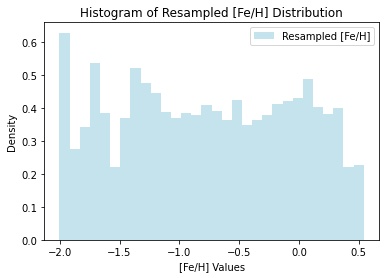

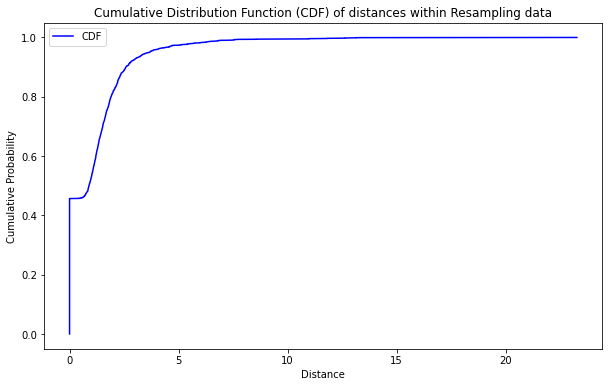

Number of data in Sequoia within the 99th percentile distance: 13
24
Number of data in Antaeus within the 99th percentile distance: 8
32
Number of data in ED2 within the 99th percentile distance: 4
24
Number of data in IoM2 within the 99th percentile distance: 3
23
Number of data in H99 within the 99th percentile distance: 42
113


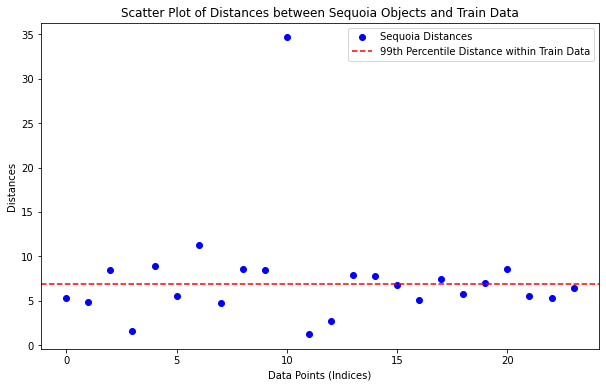

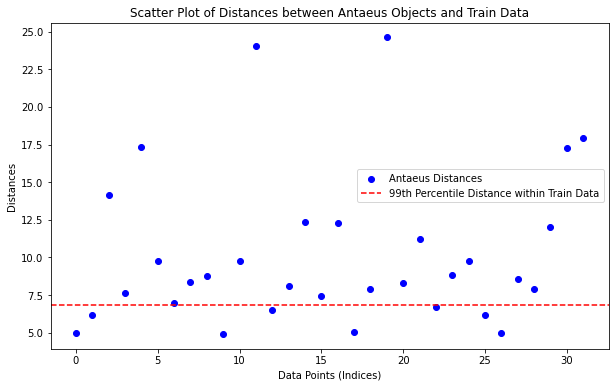

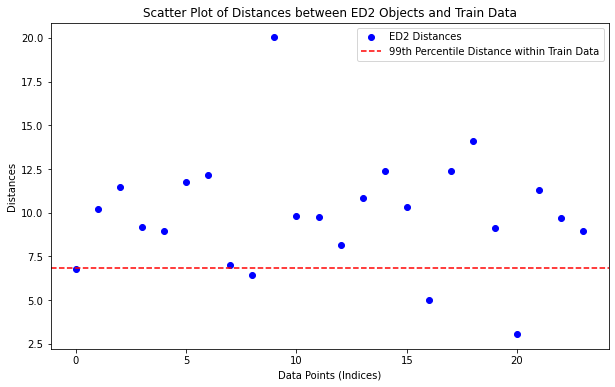

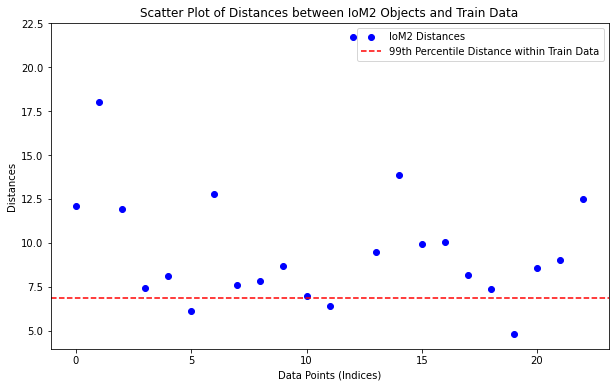

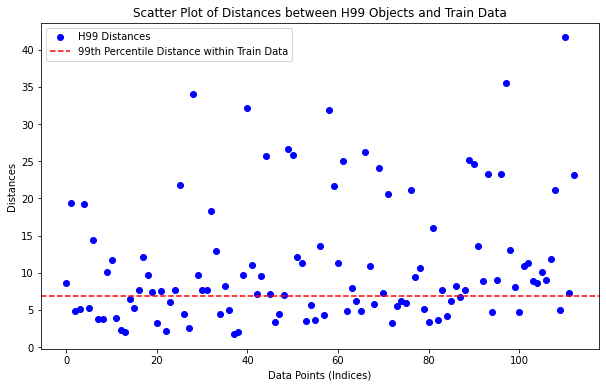

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15941.62it/s]


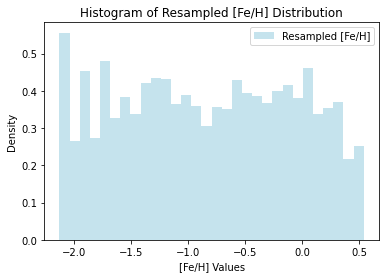

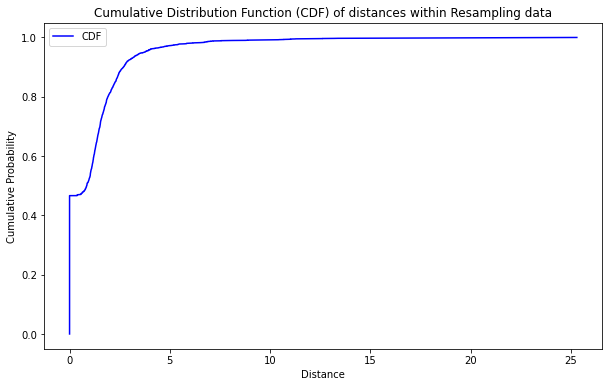

Number of data in Sequoia within the 99th percentile distance: 21
24
Number of data in Antaeus within the 99th percentile distance: 22
32
Number of data in ED2 within the 99th percentile distance: 12
24
Number of data in IoM2 within the 99th percentile distance: 17
23
Number of data in H99 within the 99th percentile distance: 72
113


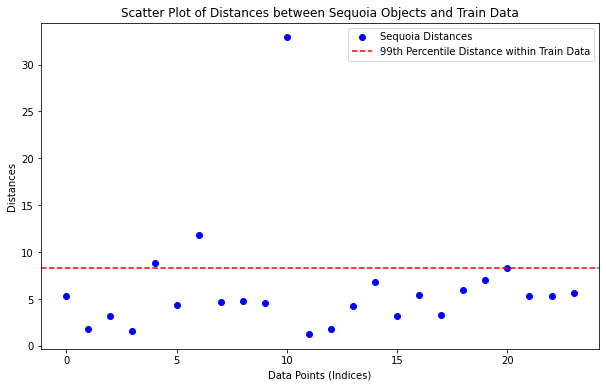

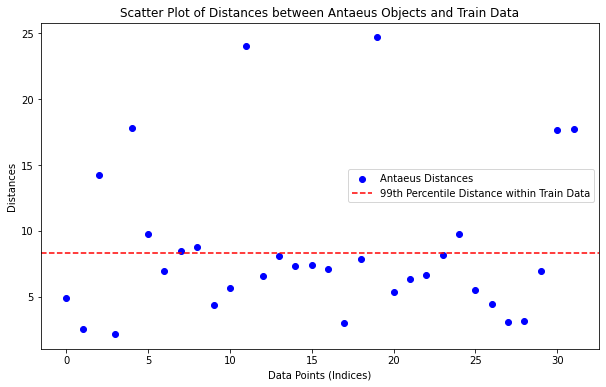

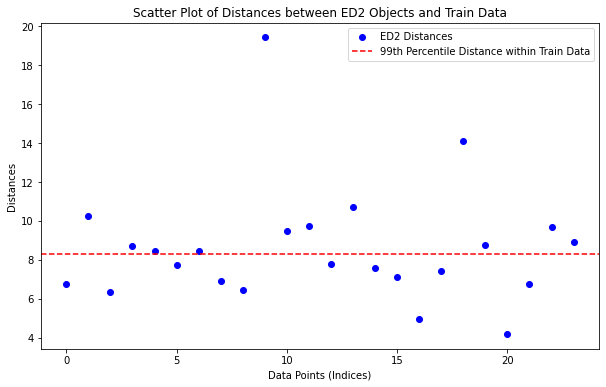

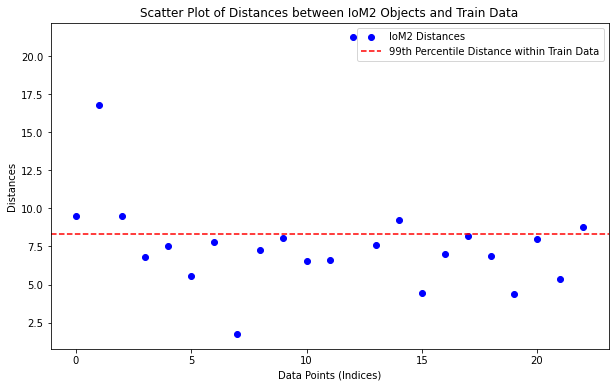

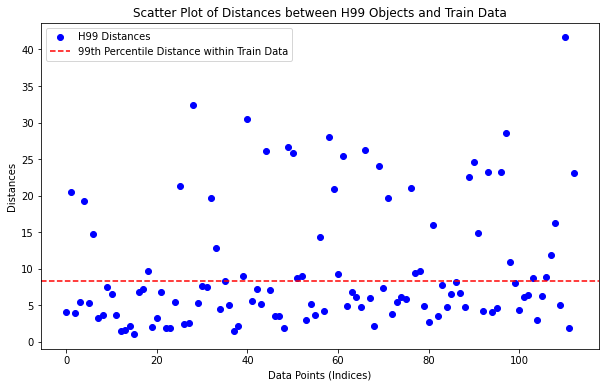

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15723.61it/s]


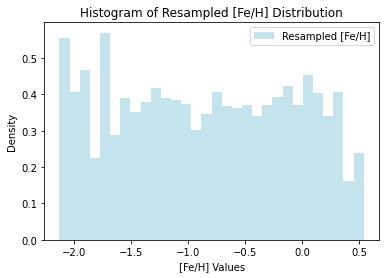

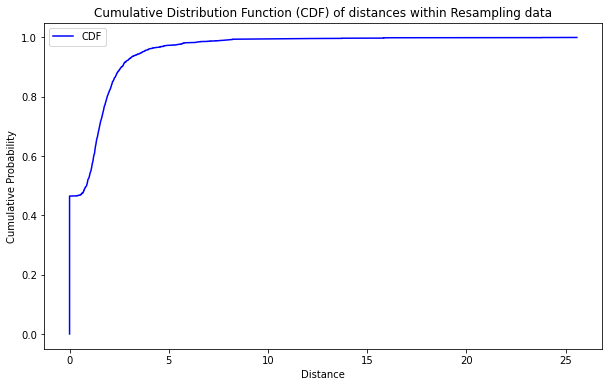

Number of data in Sequoia within the 99th percentile distance: 20
24
Number of data in Antaeus within the 99th percentile distance: 18
32
Number of data in ED2 within the 99th percentile distance: 8
24
Number of data in IoM2 within the 99th percentile distance: 13
23
Number of data in H99 within the 99th percentile distance: 65
113


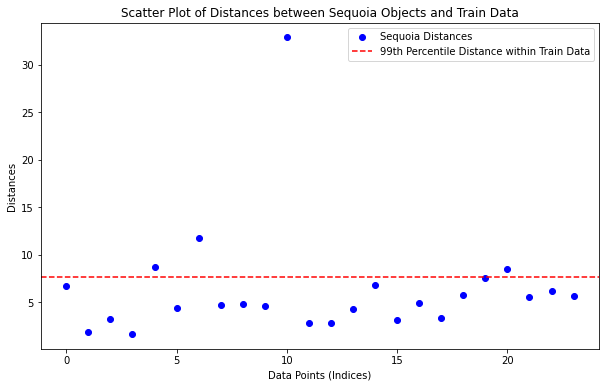

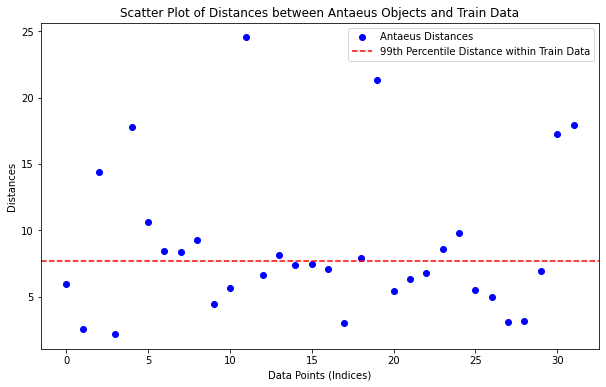

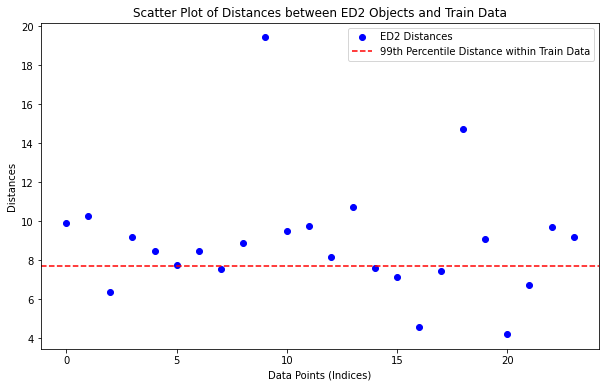

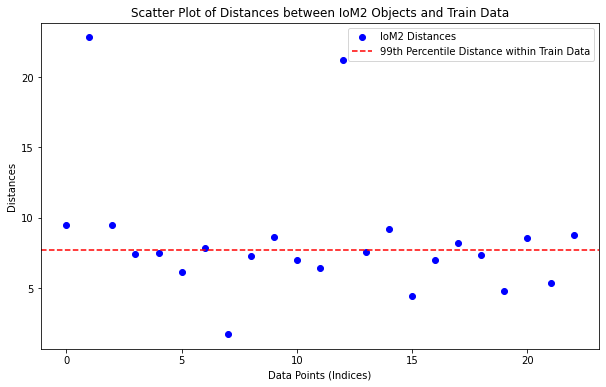

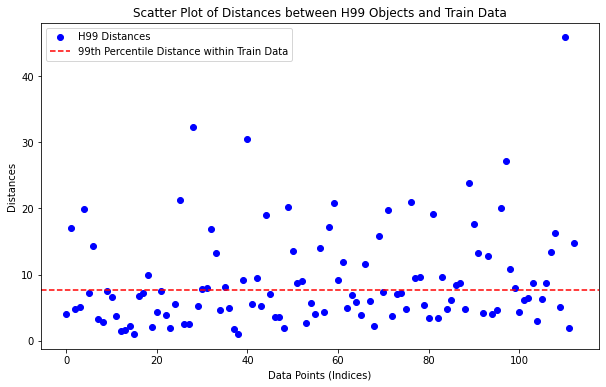

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15878.85it/s]


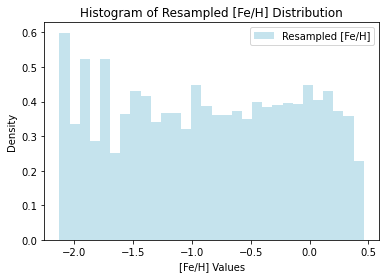

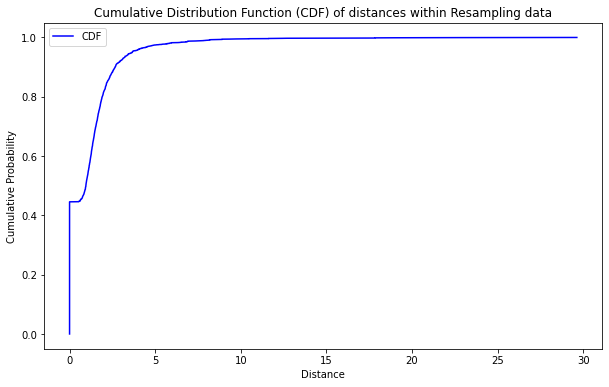

Number of data in Sequoia within the 99th percentile distance: 20
24
Number of data in Antaeus within the 99th percentile distance: 18
32
Number of data in ED2 within the 99th percentile distance: 11
24
Number of data in IoM2 within the 99th percentile distance: 14
23
Number of data in H99 within the 99th percentile distance: 68
113


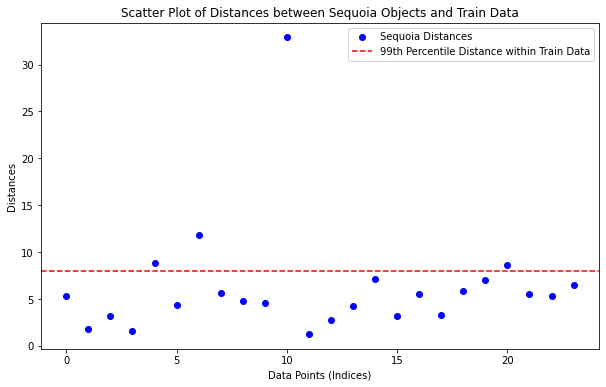

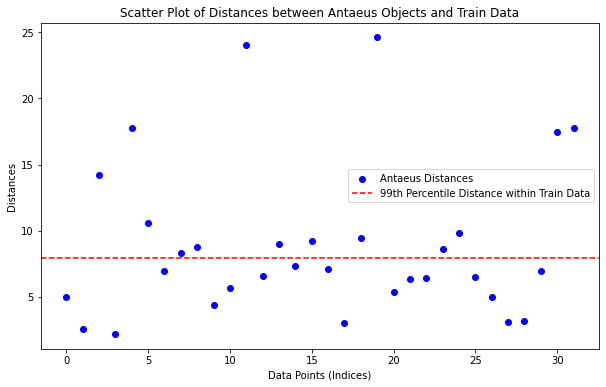

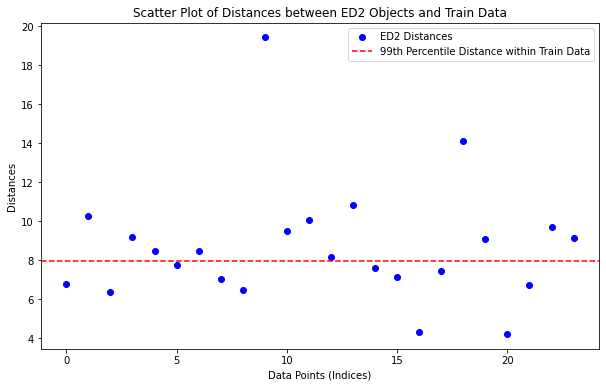

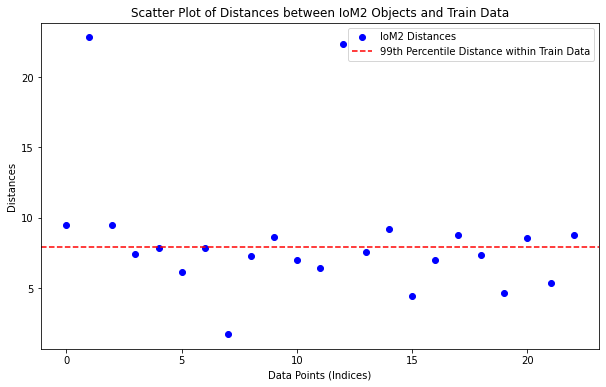

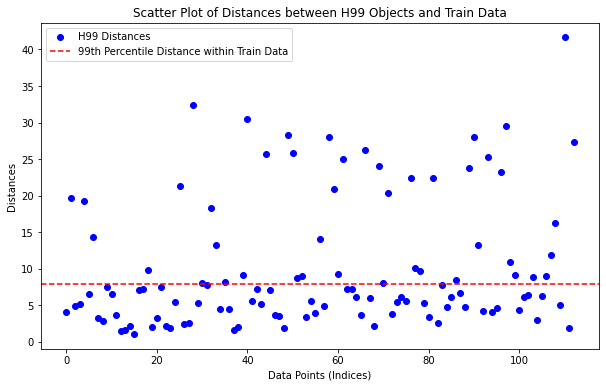

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15958.36it/s]


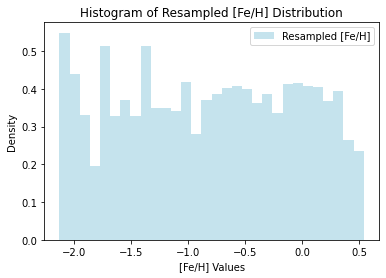

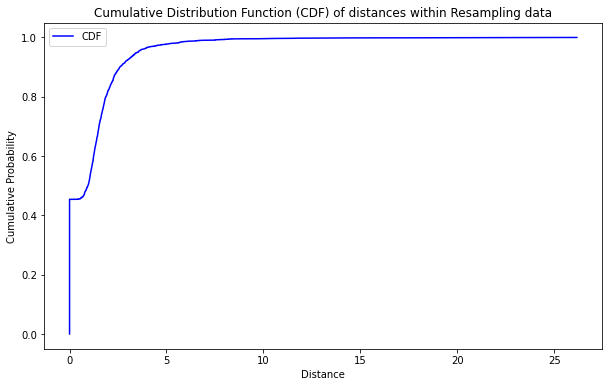

Number of data in Sequoia within the 99th percentile distance: 17
24
Number of data in Antaeus within the 99th percentile distance: 13
32
Number of data in ED2 within the 99th percentile distance: 6
24
Number of data in IoM2 within the 99th percentile distance: 6
23
Number of data in H99 within the 99th percentile distance: 58
113


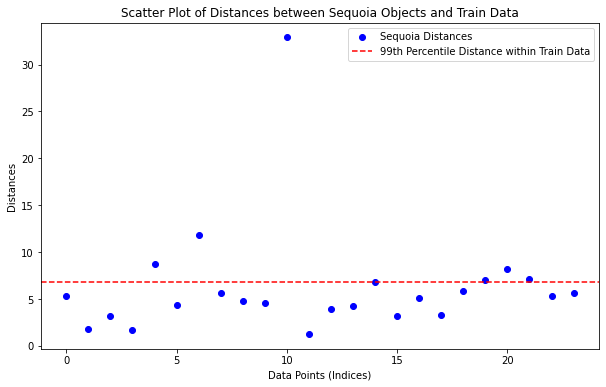

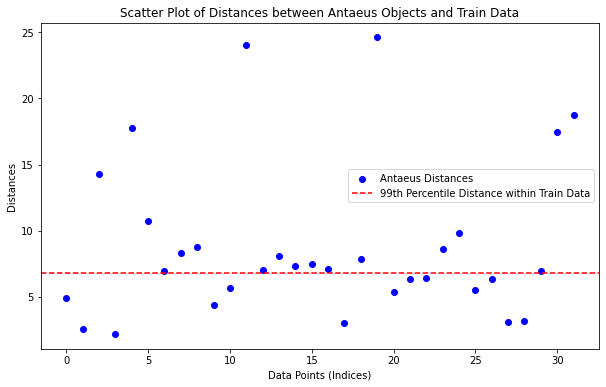

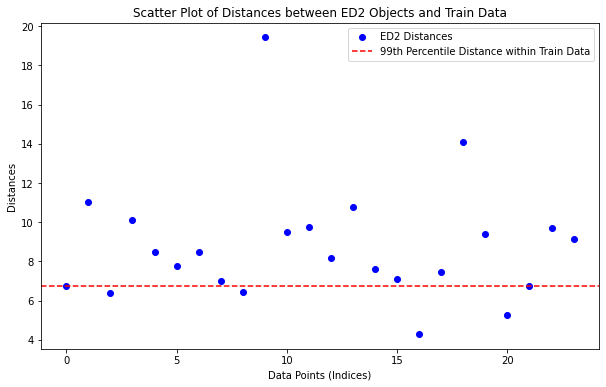

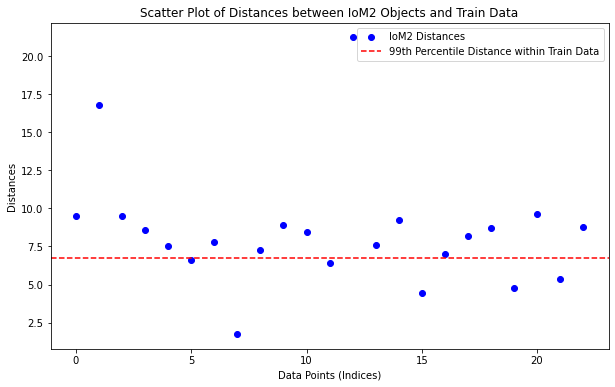

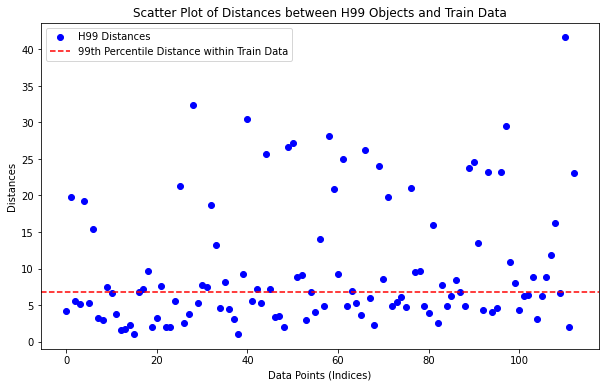

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 16213.50it/s]


In [19]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn 

num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

feh_var = []
feh_pred = []
feh_res = []
feh_exp = []

mgfe_var = []
mgfe_pred = []
mgfe_res = []
mgfe_exp = []

ofe_var = []
ofe_pred = []
ofe_res = []
ofe_exp = []

cfe_var = []
cfe_pred = []
cfe_res = []
cfe_exp = []

cife_var = []
cife_pred = []
cife_res = []
cife_exp = []


sife_var = []
sife_pred = []
sife_res = []
sife_exp = []

kfe_var = []
kfe_pred = []
kfe_res = []
kfe_exp = []

cafe_var = []
cafe_pred = []
cafe_res = []
cafe_exp = []

alfe_var = []
alfe_pred = []
alfe_res = []
alfe_exp = []

mnfe_var = []
mnfe_pred = []
mnfe_res = []
mnfe_exp = []

nife_var = []
nife_pred = []
nife_res = []
nife_exp = []

log_g_var = []
log_g_pred = []
log_g_res = []
log_g_exp = []

temperature_var = []
temperature_pred = []
temperature_res = []
temperature_exp = []



test_posterior_samples = []

all_x_test = []

all_y_test = []

# Iterate through the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, theta)):
    X_train_raw, X_test_raw = X[train_index], X[test_index]
    y_train, y_test = theta[train_index], theta[test_index]
    
    # Resampling the training set 
    
    # Retrieve the elements from the training labels
    feh_target1 = y_train[:, 0]
    mgfe_target1 = y_train[:, 1]
    ofe_target1 = y_train[:, 2]
    cfe_target1 = y_train[:, 3]
    cife_target1 = y_train[:, 4]
    sife_target1 = y_train[:, 5]
    kfe_target1 = y_train[:, 6]
    cafe_target1 = y_train[:, 7]
    alfe_target1 = y_train[:, 8]
    mnfe_target1 = y_train[:, 9]
    nife_target1 = y_train[:, 10]
    log_g1 = y_train[:, 11]
    teff1 = y_train[:, 12]
    
    # estimate the pdf of feh in the training data
    kde_feh_target = gaussian_kde(feh_target1)
    pdf_values_feh_target = kde_feh_target(feh_target1)
    normalized_pdf_values = pdf_values_feh_target / np.sum(pdf_values_feh_target)
    Px = normalized_pdf_values
    
    # Resample Uniformly and track the resampled index
    constant = feh_target1.max() - feh_target1.min()
    Qx = 1 / constant
    weights = Qx / Px
    weights /= weights.sum()
    resampled_index = np.random.choice(len(feh_target1), size=len(feh_target1), p=weights) 
    
    # get the resampled elements and data
    resampled_feh = feh_target1[resampled_index]
    resampled_mgfe = mgfe_target1[resampled_index]
    resampled_ofe = ofe_target1[resampled_index]
    resampled_cfe = cfe_target1[resampled_index]
    resampled_cife = cife_target1[resampled_index]
    resampled_sife = sife_target1[resampled_index]
    resampled_kfe = kfe_target1[resampled_index]
    resampled_cafe = cafe_target1[resampled_index]
    resampled_alfe = alfe_target1[resampled_index]
    resampled_mnfe = mnfe_target1[resampled_index]
    resampled_nife = nife_target1[resampled_index]
    resampled_log_g = log_g1[resampled_index]
    resampled_temperature = teff1[resampled_index]
    
    plt.hist(resampled_feh, bins=30, density=True, color='lightblue', alpha=0.7, label='Resampled [Fe/H]')
    plt.xlabel('[Fe/H] Values')
    plt.ylabel('Density')
    plt.title('Histogram of Resampled [Fe/H] Distribution')
    plt.legend()
    plt.show()
    
    resampled_X_train = X_train_raw[resampled_index]
    
    # create the resampled training labels and data
    
    resampled_theta = np.stack((resampled_feh, resampled_mgfe, resampled_ofe, resampled_cfe, resampled_cife, resampled_sife, resampled_kfe, resampled_cafe, resampled_alfe, resampled_mnfe, resampled_nife, 
                               resampled_log_g, resampled_temperature), axis = 1)
    
    # check the 5th Nearest Neighbor in the resampling data
    nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(resampled_X_train)
    dist_within, _ = nbrs.kneighbors(resampled_X_train)
    # 5th dist
    fifth_dist_within = dist_within[:, 5]
    
    # check the distribution of the distances within the resampling data 
    kde = gaussian_kde(fifth_dist_within)
    pdf_values = kde(fifth_dist_within)
    normalized_pdf_values = pdf_values / np.sum(pdf_values)
    cdf_values = np.cumsum(normalized_pdf_values)
    sorted_distances = np.sort(fifth_dist_within)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances, cdf_values, label='CDF', color='blue')
    plt.title('Cumulative Distribution Function (CDF) of distances within Resampling data')
    plt.xlabel('Distance')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()
    
    # 95% distance
    percentile_value = sorted_distances[np.argmax(cdf_values >= 0.99)]
    
    # check the 5 th Nearest Neighbor (between substructure and the resampling data)
    nbrs_sub = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(resampled_X_train)
    
    distances_Sequoia, indices_Sequoia = nbrs_sub.kneighbors(X_Sequoia)
    distances_Antaeus, indices_Antaeus = nbrs_sub.kneighbors(X_Antaeus)
    distances_ED2, indices_ED2 = nbrs_sub.kneighbors(X_ED2)
    distances_IoM2, indices_IoM2 = nbrs_sub.kneighbors(X_IoM2)
    distances_H99, indices_H99 = nbrs_sub.kneighbors(X_H99)
    
    fifth_distances_Sequoia = distances_Sequoia[:, 4]
    fifth_distances_Antaeus = distances_Antaeus[:, 4]
    fifth_distances_ED2 = distances_ED2[:, 4]
    fifth_distances_IoM2 = distances_IoM2[:, 4]
    fifth_distances_H99 = distances_H99[:, 4]
    
    Sequoia_within = np.sum(fifth_distances_Sequoia <=  percentile_value)
    Antaeus_within = np.sum(fifth_distances_Antaeus <=  percentile_value)
    ED2_within = np.sum(fifth_distances_ED2 <=  percentile_value)
    IoM2_within = np.sum(fifth_distances_IoM2 <=  percentile_value)
    H99_within = np.sum(fifth_distances_H99 <=  percentile_value)

    print(f"Number of data in Sequoia within the 99th percentile distance: {Sequoia_within}")
    print(len(X_Sequoia))
    print(f"Number of data in Antaeus within the 99th percentile distance: {Antaeus_within}")
    print(len(X_Antaeus))
    print(f"Number of data in ED2 within the 99th percentile distance: {ED2_within}")
    print(len(X_ED2))
    print(f"Number of data in IoM2 within the 99th percentile distance: {IoM2_within}")
    print(len(X_IoM2))
    print(f"Number of data in H99 within the 99th percentile distance: {H99_within}")
    print(len(X_H99))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(fifth_distances_Sequoia)), fifth_distances_Sequoia, color='blue', label='Sequoia Distances')
    plt.axhline(y=percentile_value, color='red', linestyle='--', label='99th Percentile Distance within Train Data')
    plt.title('Scatter Plot of Distances between Sequoia Objects and Train Data')
    plt.xlabel('Data Points (Indices)')
    plt.ylabel('Distances')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(fifth_distances_Antaeus)), fifth_distances_Antaeus, color='blue', label='Antaeus Distances')
    plt.axhline(y=percentile_value, color='red', linestyle='--', label='99th Percentile Distance within Train Data')
    plt.title('Scatter Plot of Distances between Antaeus Objects and Train Data')
    plt.xlabel('Data Points (Indices)')
    plt.ylabel('Distances')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(fifth_distances_ED2)), fifth_distances_ED2, color='blue', label='ED2 Distances')
    plt.axhline(y=percentile_value, color='red', linestyle='--', label='99th Percentile Distance within Train Data')
    plt.title('Scatter Plot of Distances between ED2 Objects and Train Data')
    plt.xlabel('Data Points (Indices)')
    plt.ylabel('Distances')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(fifth_distances_IoM2)), fifth_distances_IoM2, color='blue', label='IoM2 Distances')
    plt.axhline(y=percentile_value, color='red', linestyle='--', label='99th Percentile Distance within Train Data')
    plt.title('Scatter Plot of Distances between IoM2 Objects and Train Data')
    plt.xlabel('Data Points (Indices)')
    plt.ylabel('Distances')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(fifth_distances_H99)), fifth_distances_H99, color='blue', label='H99 Distances')
    plt.axhline(y=percentile_value, color='red', linestyle='--', label='99th Percentile Distance within Train Data')
    plt.title('Scatter Plot of Distances between H99 Objects and Train Data')
    plt.xlabel('Data Points (Indices)')
    plt.ylabel('Distances')
    plt.legend()
    plt.show()
    
    
    
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(resampled_X_train)
    X_train = scaler.transform(resampled_X_train)
    X_test = scaler.transform(X_test_raw)

    # Convert to PyTorch tensors
    X_train = torch.Tensor(X_train)
    X_test = torch.Tensor(X_test)
    resampled_theta_tensor = torch.Tensor(resampled_theta)
    y_test = torch.Tensor(y_test)

    # SNPE Inference
    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            
            self.model = nn.Sequential(
                nn.Linear(13787, 4000),
                nn.GELU(),
                nn.Linear(4000, 2000),
                nn.GELU(),
                nn.Linear(2000, 1000),
                nn.GELU(),
                nn.Linear(1000, 500),
                nn.GELU(),
                nn.Linear(500, 100),
                nn.GELU(),
                nn.Linear(100, 50))

        
        def forward(self, x):
            return self.model(x)
    
    neural_posterior = utils.posterior_nn(model="nsf", embedding_net=Model(), hidden_features=50, num_transforms=5)
    inference = SNPE(density_estimator=neural_posterior)
    inference.append_simulations(resampled_theta_tensor, X_train)
    #density_estimator = inference.train() 
    #posterior = inference.build_posterior(density_estimator)
    
    # load the model
    model_pkl_file = f"GB_SBI_Unif_fold_{fold}.pkl" 
    
    with open(model_pkl_file, 'rb') as file:
        posterior = pickle.load(file)
    
    all_x_test.append(X_test)
    all_y_test.append(y_test)
    
    # Calculate residuals, predictions, and variances for each observation in the test set
    n_samples = 250

    for idx in range(len(X_test)):
        samples = posterior.sample((n_samples,), x=X_test[idx])
        fe_h = samples[:, 0]
        mg_fe = samples[:, 1]
        o_fe = samples[:, 2]
        c_fe = samples[:, 3]
        ci_fe = samples[:, 4]
        si_fe = samples[:, 5]
        k_fe = samples[:, 6]
        ca_fe = samples[:, 7]
        al_fe = samples[:, 8]
        mn_fe = samples[:, 9]
        ni_fe = samples[:, 10]
        log_g = samples[:, 11]
        teff = samples[:, 12]
        
        # samples for Tarp
        test_posterior_samples.append(samples)
        # feh
        feh_exp.append(y_test[idx][0])
        feh_res.append(y_test[idx][0] - torch.mean(fe_h))
        feh_pred.append(torch.mean(fe_h))
        feh_var.append(torch.var(fe_h))
        # mgfe
        mgfe_exp.append(y_test[idx][1])
        mgfe_res.append(y_test[idx][1] - torch.mean(mg_fe))
        mgfe_pred.append(torch.mean(mg_fe))
        mgfe_var.append(torch.var(mg_fe)) 
        # ofe
        ofe_exp.append(y_test[idx][2])
        ofe_res.append(y_test[idx][2] - torch.mean(o_fe))
        ofe_pred.append(torch.mean(o_fe))
        ofe_var.append(torch.var(o_fe))
        # cfe
        cfe_exp.append(y_test[idx][3])
        cfe_res.append(y_test[idx][3] - torch.mean(c_fe))
        cfe_pred.append(torch.mean(c_fe))
        cfe_var.append(torch.var(c_fe))
        # cife
        cife_exp.append(y_test[idx][4])
        cife_res.append(y_test[idx][4] - torch.mean(ci_fe))
        cife_pred.append(torch.mean(ci_fe))
        cife_var.append(torch.var(ci_fe))
        # sife
        sife_exp.append(y_test[idx][5])
        sife_res.append(y_test[idx][5] - torch.mean(si_fe))
        sife_pred.append(torch.mean(si_fe))
        sife_var.append(torch.var(si_fe))
        # kfe
        kfe_exp.append(y_test[idx][6])
        kfe_res.append(y_test[idx][6] - torch.mean(k_fe))
        kfe_pred.append(torch.mean(k_fe))
        kfe_var.append(torch.var(k_fe))
        # cafe
        cafe_exp.append(y_test[idx][7])
        cafe_res.append(y_test[idx][7] - torch.mean(ca_fe))
        cafe_pred.append(torch.mean(ca_fe))
        cafe_var.append(torch.var(ca_fe))
        # alfe
        alfe_exp.append(y_test[idx][8])
        alfe_res.append(y_test[idx][8] - torch.mean(al_fe))
        alfe_pred.append(torch.mean(al_fe))
        alfe_var.append(torch.var(al_fe))
        # mnfe
        mnfe_exp.append(y_test[idx][9])
        mnfe_res.append(y_test[idx][9] - torch.mean(mn_fe))
        mnfe_pred.append(torch.mean(mn_fe))
        mnfe_var.append(torch.var(mn_fe))
        # nife
        nife_exp.append(y_test[idx][10])
        nife_res.append(y_test[idx][10] - torch.mean(ni_fe))
        nife_pred.append(torch.mean(ni_fe))
        nife_var.append(torch.var(ni_fe))
        
        # log_g
        log_g_exp.append(y_test[idx][11])
        log_g_res.append(y_test[idx][11] - torch.mean(log_g))
        log_g_pred.append(torch.mean(log_g))
        log_g_var.append(torch.var(log_g))
        
        # temperature
        temperature_exp.append(y_test[idx][12])
        temperature_res.append(y_test[idx][12] - torch.mean(teff))
        temperature_pred.append(torch.mean(teff))
        temperature_var.append(torch.var(teff))  
    
    # save the posterior
    # first way
    #model_pkl_file = f"GB_SBI_Unif_fold_{fold}.pkl" 

    #with open(model_pkl_file, 'wb') as file:  
        #pickle.dump(posterior, file)
    
    # another way to save it
    #save_directory = 'GB_Unif_SBI'
    #os.makedirs(save_directory, exist_ok=True)
    #torch.save(posterior, f'{save_directory}posterior_fold_{fold}.pt')


In [ ]:
# run sbc
num_posterior_samples = 1000
ranks, dap_samples = run_sbc(y_test, X_test, posterior, num_posterior_samples=num_posterior_samples, reduce_fns='marginals')

In [ ]:
check_stats = check_sbc(
    ranks, y_test, dap_samples, num_posterior_samples=num_posterior_samples
)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)

In [ ]:
from sbi.analysis import sbc_rank_plot


f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    parameter_labels = ['Fe/H', 'Mg/Fe', 'O/Fe', 'C/Fe', 'CI/Fe', 'Si/Fe', 'K/Fe', 'Ca/Fe', 'Al/Fe', 'Mn/Fe', 'Ni/Fe', 
                        'Log_g', 'Teff'],
    plot_type="hist",
    num_bins=None)

In [ ]:
f, ax = sbc_rank_plot(ranks, 1_000, parameter_labels = ['Fe/H', 'Mg/Fe', 'O/Fe', 'C/Fe', 'CI/Fe', 'Si/Fe', 'K/Fe', 'Ca/Fe', 'Al/Fe', 'Mn/Fe', 'Ni/Fe',
                                                       'Log_g', 'Teff'], 
                      plot_type="cdf")

In [ ]:
posterior_samples = torch.cat(test_posterior_samples[:1516], dim = 0)

In [ ]:
posterior_samples = posterior_samples.numpy()

In [ ]:
n_dims = 13
n_samples = 250
posterior_samples = posterior_samples.reshape((n_samples, len(X_test), n_dims))
theta_arr = y_test.numpy()
# Check the shape of the posterior samples array and theta array
print(posterior_samples.shape)
print(theta_arr.shape)

In [ ]:
# Tarp
import tarp
coverage_values, ecp = tarp.get_drp_coverage(posterior_samples, theta_arr, references='random', metric='euclidean')

In [ ]:
plt.plot(coverage_values, ecp, marker='o')
plt.xlabel("Credibility Level")
plt.ylabel("Expected Coverage Probability")
plt.title("Credibility Level vs. Expected Coverage Probability")
plt.grid(True)
plt.show()

In [ ]:
significance_level = 0.05

# Step 2: Compare each ECP value with the significance level
is_significant = ecp <= significance_level

# Step 3: Calculate the p-value
p_value = is_significant.mean()

print("p-value:", p_value)

In [20]:
feh_res = torch.stack(feh_res)
feh_var = torch.stack(feh_var)
feh_pred = torch.stack(feh_pred)
feh_exp = torch.stack(feh_exp)

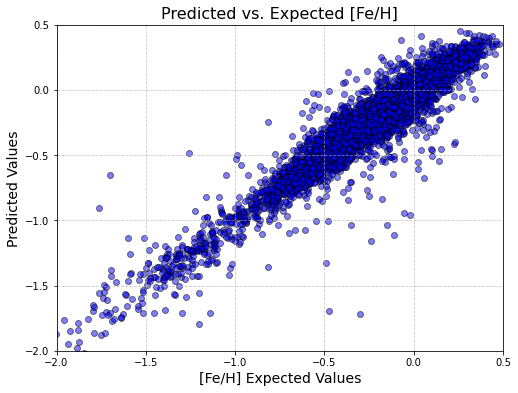

In [21]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.scatter(feh_exp, feh_pred, alpha=0.5, color='b', edgecolors='k', marker='o')
plt.xlim(-2, 0.5)
plt.ylim(-2, 0.5)
plt.xlabel("[Fe/H] Expected Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Expected [Fe/H]", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [22]:
cmap = colours.LinearSegmentedColormap.from_list('greenblue', ['white', 'dodgerblue', 'dodgerblue', 'royalblue', 
                                                               'royalblue', 'mediumblue', 'mediumblue', 
                                                               'midnightblue'])


In [23]:
feh_res = np.array(feh_res)
feh_res = -feh_res
feh_exp = np.array(feh_exp)

In [24]:
xbin = np.linspace(-2, 0.5, 100)

In [25]:
lower = [] # -1 sigma
median = []
upper = [] # +1 sigma
center = []
for n in range(len(xbin)-1):
    edges = [i for i in range(len(feh_exp)) if (feh_exp[i] >= xbin[n] and feh_exp[i] < xbin[n+1])]
    residual = [] 
    if edges:
        c = (xbin[n + 1] + xbin[n]) / 2 # find the center of the bins where I'll put my points 
        center.append(c)
        for k in edges:
            residual.append(feh_res[k]) # append all the residuals 
        p = np.percentile(residual, (16, 50, 84)) # find where +-1 sigma and median are
        lower.append(p[0])
        median.append(p[1])
        upper.append(p[2])

In [26]:
l = np.interp(xbin, center, lower) 
m = np.interp(xbin, center, median)
u = np.interp(xbin, center, upper)

In [27]:
desi_feh = np.array(sp_tab_masked['Fe_H_sp'])
xbin1 = np.linspace(-2, 0.5, 100)
r1 = np.array(desi_feh) - np.array(feh_target)

In [28]:
lower1 = []
median1 = []
upper1 = []
center1 = []
for n in range(len(xbin1)-1):
    edges = [i for i in range(len(feh_exp)) if (feh_exp[i] >= xbin1[n] and feh_exp[i]< xbin1[n+1])]
    residual = []
    if edges:
        c = (xbin1[n+1] + xbin1[n])/2
        center1.append(c)
        for k in edges:
            residual.append(r1[k])
        p = np.percentile(residual, (16, 50, 84))
        lower1.append(p[0])
        median1.append(p[1])
        upper1.append(p[2])

In [29]:
l1 = np.interp(xbin1, center1, lower1)
m1 = np.interp(xbin1, center1, median1)
u1 = np.interp(xbin1, center1, upper1)

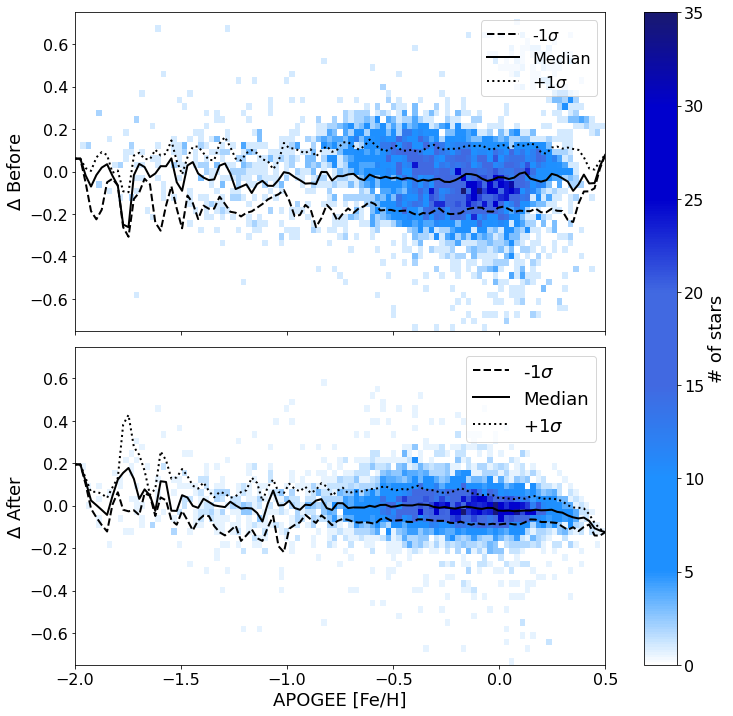

In [30]:
# Plot the 2D histograms! 
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,12))
ax1 = plt.subplot(2, 1, 1)
h1, x, y, i = plt.hist2d(feh_target, r1, bins = (np.linspace(-2, 0.5, 100), np.linspace(-0.75, 0.75, 50)), 
                         cmap = cmap)
plt.plot(xbin1, l1, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin1, m1, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin1, u1, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.ylabel('$\Delta$ Before', fontsize = 18)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
ax1.tick_params(axis = 'x', labelbottom=False)
im1 = ax1.imshow(h1, cmap = cmap)


ax2 = plt.subplot(2, 1, 2, sharex=ax1)
h2, x, y, i = plt.hist2d(feh_exp, feh_res, bins = (np.linspace(-2, 0.5, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin, l, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin, m, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin, u, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.xlabel('APOGEE [Fe/H]', fontsize = 18)
plt.ylabel('$\Delta$ After', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 18)
plt.subplots_adjust(hspace = 0.05)
im2 = ax2.imshow(h2, cmap = cmap)

cbar = fig.colorbar(im1, ax=(ax1, ax2))
cbar.ax.tick_params(labelsize = 16) 
cbar.set_label('# of stars', fontsize = 18)

In [31]:
mgfe_res = torch.stack(mgfe_res)
mgfe_pred = torch.stack(mgfe_pred)
mgfe_exp = torch.stack(mgfe_exp)

cfe_res = torch.stack(cfe_res)
cfe_pred = torch.stack(cfe_pred)
cfe_exp = torch.stack(cfe_exp)

sife_res = torch.stack(sife_res)
sife_pred = torch.stack(sife_pred)
sife_exp = torch.stack(sife_exp)

cafe_res = torch.stack(cafe_res)
cafe_pred = torch.stack(cafe_pred)
cafe_exp = torch.stack(cafe_exp)

alfe_res = torch.stack(alfe_res)
alfe_pred = torch.stack(alfe_pred)
alfe_exp = torch.stack(alfe_exp)


nife_res = torch.stack(nife_res)
nife_pred = torch.stack(nife_pred)
nife_exp = torch.stack(nife_exp)

kfe_res = torch.stack(kfe_res)
kfe_pred = torch.stack(kfe_pred)
kfe_exp = torch.stack(kfe_exp)

log_g_res = torch.stack(log_g_res)
log_g_pred = torch.stack(log_g_pred)
log_g_exp = torch.stack(log_g_exp)

temperature_res = torch.stack(temperature_res)
temperature_pred = torch.stack(temperature_pred)
temperature_exp = torch.stack(temperature_exp)

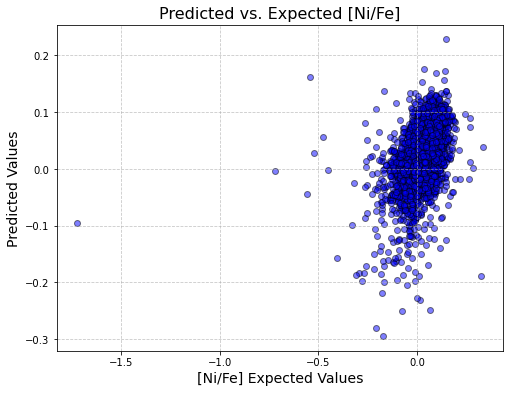

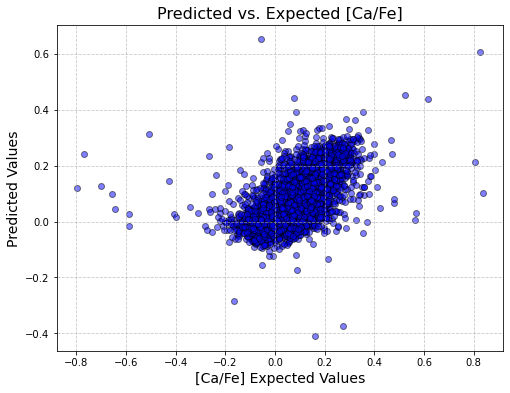

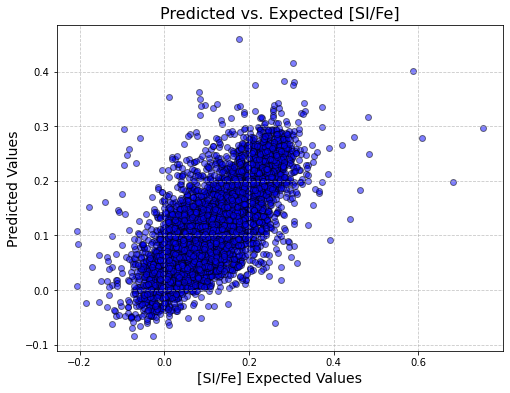

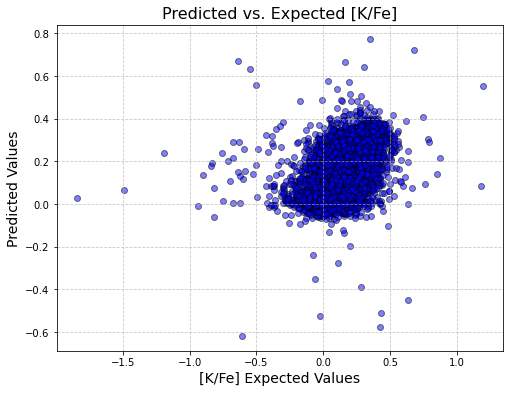

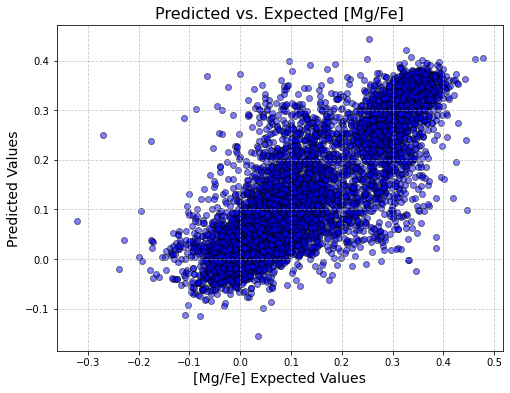

In [32]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.scatter(nife_exp, nife_pred, alpha=0.5, color='b', edgecolors='k', marker='o')

plt.xlabel("[Ni/Fe] Expected Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Expected [Ni/Fe]", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.scatter(cafe_exp, cafe_pred, alpha=0.5, color='b', edgecolors='k', marker='o')

plt.xlabel("[Ca/Fe] Expected Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Expected [Ca/Fe]", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.scatter(sife_exp, sife_pred, alpha=0.5, color='b', edgecolors='k', marker='o')

plt.xlabel("[SI/Fe] Expected Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Expected [SI/Fe]", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.scatter(kfe_exp, kfe_pred, alpha=0.5, color='b', edgecolors='k', marker='o')

plt.xlabel("[K/Fe] Expected Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Expected [K/Fe]", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.scatter(mgfe_exp, mgfe_pred, alpha=0.5, color='b', edgecolors='k', marker='o')

plt.xlabel("[Mg/Fe] Expected Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Expected [Mg/Fe]", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [33]:
nife_res = np.array(nife_res)
nife_pred = np.array(nife_pred)
nife_exp = np.array(nife_exp)

cafe_res = np.array(cafe_res)
cafe_pred = np.array(cafe_pred)
cafe_exp = np.array(cafe_exp)

sife_res = np.array(sife_res)
sife_pred = np.array(sife_pred)
sife_exp = np.array(sife_exp)

cfe_res = np.array(cfe_res)
cfe_pred = np.array(cfe_pred)
cfe_exp = np.array(cfe_exp)

mgfe_res = np.array(mgfe_res)
mgfe_pred = np.array(mgfe_pred)
mgfe_exp = np.array(mgfe_exp)

log_g_res = np.array(log_g_res)
log_g_pred = np.array(log_g_pred)
log_g_exp = np.array(log_g_exp)

temperature_res = np.array(temperature_res)
temperature_pred = np.array(temperature_pred)
temperature_exp = np.array(temperature_exp)

In [34]:
r0 = np.array(feh_pred) - np.array(feh_exp)
print(np.mean(r0))
print(np.median(r0))
percentile_16 = np.percentile(r0, 16)
percentile_84 = np.percentile(r0, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of feh_res:", iqr_value)
print("Standard deviation of feh_res:", np.std(r0))
print("Population variance:", np.var(r0))

feh_var = np.array(feh_var)
print("Mean of Variances:", np.mean(feh_var))

-0.010740724
-0.012493812
Interquartile Range (IQR) of feh_res: 0.07245404347777365
Standard deviation of feh_res: 0.10350959
Population variance: 0.010714235
Mean of Variances: 0.0035578378


In [35]:
r1 = np.array(mgfe_pred) - np.array(mgfe_exp)
print(np.mean(r1))
print(np.median(r1))
percentile_16 = np.percentile(r1, 16)
percentile_84 = np.percentile(r1, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of mgfe_res:", iqr_value)
print("Standard deviation of mgfe_res:", np.std(r1))
print("Population variance:", np.var(r1))
#mgfe_var = torch.stack(mgfe_var)
mgfe_var = np.array(mgfe_var)
print("Mean of Variances:", np.mean(mgfe_var))

0.0024643526
0.0016200691
Interquartile Range (IQR) of mgfe_res: 0.0588035725057125
Standard deviation of mgfe_res: 0.07519953
Population variance: 0.0056549693
Mean of Variances: 0.0022791738


In [36]:
r2 = np.array(ofe_pred) - np.array(ofe_exp)
print(np.mean(r2))
print(np.median(r2))
percentile_16 = np.percentile(r2, 16)
percentile_84 = np.percentile(r2, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of cfe_res:", iqr_value)
print("Standard deviation of cfe_res:", np.std(r2))
print("Population variance:", np.var(r2))
#cfe_var = torch.stack(cfe_var)
cfe_var = np.array(ofe_var)
print("Mean of Variances:", np.mean(ofe_var))

0.003955969
0.00063056813
Interquartile Range (IQR) of cfe_res: 0.09268461689352989
Standard deviation of cfe_res: 0.1180745
Population variance: 0.013941587
Mean of Variances: 0.0075129783


In [37]:
r3 = np.array(cfe_pred) - np.array(cfe_exp)
print(np.mean(r3))
print(np.median(r3))
percentile_16 = np.percentile(r3, 16)
percentile_84 = np.percentile(r3, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of cfe_res:", iqr_value)
print("Standard deviation of cfe_res:", np.std(r3))
print("Population variance:", np.var(r3))
#cfe_var = torch.stack(cfe_var)
cfe_var = np.array(cfe_var)
print("Mean of Variances:", np.mean(cfe_var))

0.0009440115
-0.0008381633
Interquartile Range (IQR) of cfe_res: 0.07172445356845855
Standard deviation of cfe_res: 0.09193259
Population variance: 0.008451601
Mean of Variances: 0.0075129783


In [38]:
r4 = np.array(cife_pred) - np.array(cife_exp)
print(np.mean(r4))
print(np.median(r4))
percentile_16 = np.percentile(r4, 16)
percentile_84 = np.percentile(r4, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of cfe_res:", iqr_value)
print("Standard deviation of cfe_res:", np.std(r4))
print("Population variance:", np.var(r4))
#cfe_var = torch.stack(cfe_var)
cfe_var = np.array(cife_var)
print("Mean of Variances:", np.mean(cife_var))

0.0013303031
-9.779446e-05
Interquartile Range (IQR) of cfe_res: 0.08874368593096732
Standard deviation of cfe_res: 0.113825634
Population variance: 0.012956276
Mean of Variances: 0.0055778422


In [39]:
r6 = np.array(sife_pred) - np.array(sife_exp)
print(np.mean(r6))
print(np.median(r6))
percentile_16 = np.percentile(r6, 16)
percentile_84 = np.percentile(r6, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of sife_res:", iqr_value)
print("Standard deviation of sife_res:", np.std(r6))
print("Population variance:", np.var(r6))
#sife_var = torch.stack(sife_var)
sife_var = np.array(sife_var)
print("Mean of Variances:", np.mean(sife_var))

0.0031278508
0.001700338
Interquartile Range (IQR) of sife_res: 0.04838852360844611
Standard deviation of sife_res: 0.058941744
Population variance: 0.0034741291
Mean of Variances: 0.0014373024


In [40]:
r7 = np.array(kfe_pred) - np.array(kfe_exp)
print(np.mean(r7))
print(np.median(r7))
percentile_16 = np.percentile(r7, 16)
percentile_84 = np.percentile(r7, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of kfe_res:", iqr_value)
print("Standard deviation of kfe_res:", np.std(r7))
print("Population variance:", np.var(r7))
#kfe_var = torch.stack(kfe_var)
kfe_var = np.array(kfe_var)
print("Mean of Variances:", np.mean(kfe_var))

0.0038835115
0.0007277471
Interquartile Range (IQR) of kfe_res: 0.10717053711414333
Standard deviation of kfe_res: 0.1424901
Population variance: 0.02030343
Mean of Variances: 0.013152936


In [41]:
r8 = np.array(cafe_pred) - np.array(cafe_exp)
print(np.mean(r8))
print(np.median(r8))
percentile_16 = np.percentile(r8, 16)
percentile_84 = np.percentile(r8, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of cafe_res:", iqr_value)
print("Standard deviation of cafe_res:", np.std(r8))
print("Population variance:", np.var(r8))
#cafe_var = torch.stack(cafe_var)
cafe_var = np.array(cafe_var)
print("Mean of Variances:", np.mean(cafe_var))

0.0019342969
0.0029681402
Interquartile Range (IQR) of cafe_res: 0.05262692049145698
Standard deviation of cafe_res: 0.074188955
Population variance: 0.0055040014
Mean of Variances: 0.002579437


In [42]:
r_al = np.array(alfe_pred) - np.array(alfe_exp)
print(np.mean(r_al))
print(np.median(r_al))
percentile_16 = np.percentile(r_al, 16)
percentile_84 = np.percentile(r_al, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of alfe_res:", iqr_value)
print("Standard deviation of alfe_res:", np.std(r_al))
print("Population variance:", np.var(r_al))
#cafe_var = torch.stack(cafe_var)
cafe_var = np.array(alfe_var)
print("Mean of Variances:", np.mean(alfe_var))

0.003877513
0.004427977
Interquartile Range (IQR) of alfe_res: 0.07688952535390853
Standard deviation of alfe_res: 0.095309466
Population variance: 0.009083894
Mean of Variances: 0.0038814624


In [43]:
r9 = np.array(mnfe_pred) - np.array(mnfe_exp)
print(np.mean(r9))
print(np.median(r9))
percentile_16 = np.percentile(r9, 16)
percentile_84 = np.percentile(r9, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of cafe_res:", iqr_value)
print("Standard deviation of cafe_res:", np.std(r9))
print("Population variance:", np.var(r9))
#cafe_var = torch.stack(cafe_var)
cafe_var = np.array(mnfe_var)
print("Mean of Variances:", np.mean(mnfe_var))

-0.0045694923
-0.0049826913
Interquartile Range (IQR) of cafe_res: 0.050137739628553384
Standard deviation of cafe_res: 0.07670187
Population variance: 0.0058831777
Mean of Variances: 0.0030310398


In [44]:
r10 = np.array(nife_pred) - np.array(nife_exp)
print(np.mean(r10))
print(np.median(r10))
percentile_16 = np.percentile(r10, 16)
percentile_84 = np.percentile(r10, 84)
iqr_value = (percentile_84 - percentile_16) / 2
# Print or use the iqr_value as needed
print("Interquartile Range (IQR) of nife_res:", iqr_value)
print("Standard deviation of nife_res:", np.std(r10))
print("Population variance:", np.var(r10))
#nife_var = torch.stack(nife_var)
nife_var = np.array(nife_var)
print("Mean of Variances:", np.mean(nife_var))

-0.0023838286
-0.0039034365
Interquartile Range (IQR) of nife_res: 0.04027848541736602
Standard deviation of nife_res: 0.055512816
Population variance: 0.0030816728
Mean of Variances: 0.0019979319


In [45]:
r_log_g = np.array(log_g_pred) - np.array(log_g_exp)
print(np.mean(r_log_g))
print(np.median(r_log_g))
percentile_16 = np.percentile(r_log_g, 16)
percentile_84 = np.percentile(r_log_g, 84)
iqr_value = (percentile_84 - percentile_16) / 2
print("Interquartile Range (IQR) of log_g:", iqr_value)
print("Standard deviation of log_g:", np.std(r_log_g))
print("Population variance:", np.var(r_log_g))
log_g_var = np.array(log_g_var)
print("Mean of Variances:", np.mean(log_g_var))

-0.00799632
-0.009496689
Interquartile Range (IQR) of log_g: 0.11026227474212644
Standard deviation of log_g: 0.21592656
Population variance: 0.046624277
Mean of Variances: 0.014000195


In [46]:
r_teff = np.array(temperature_pred) - np.array(temperature_exp)
print(np.mean(r_teff))
print(np.median(r_teff))
percentile_16 = np.percentile(r_teff, 16)
percentile_84 = np.percentile(r_teff, 84)
iqr_value = (percentile_84 - percentile_16) / 2
print("Interquartile Range (IQR) of teff:", iqr_value)
print("Standard deviation of teff:", np.std(r_teff))
print("Population variance:", np.var(r_teff))
temperature_var = np.array(temperature_var)
print("Mean of Variances:", np.mean(temperature_var))

1.9781424
-2.354004
Interquartile Range (IQR) of log_g: 78.96025390624999
Standard deviation of log_g: 120.94507
Population variance: 14627.71
Mean of Variances: 5935.1323


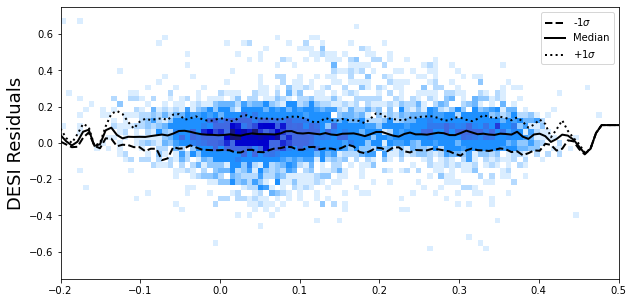

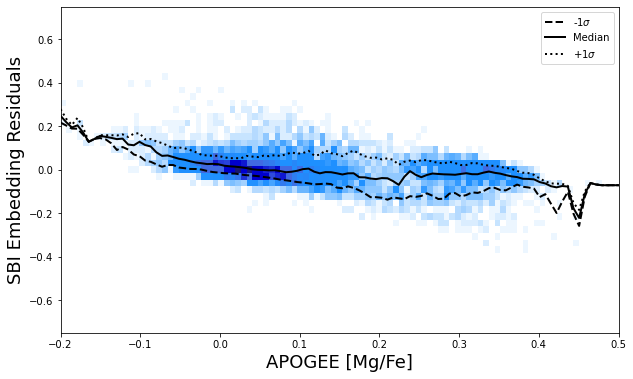

In [47]:
xbin = np.linspace(-0.2, 0.5, 100)
lower = [] # -1 sigma
median = []
upper = [] # +1 sigma
center = []
for n in range(len(xbin)-1):
    edges = [i for i in range(len(mgfe_exp)) if (mgfe_exp[i] >= xbin[n] and mgfe_exp[i] < xbin[n+1])]
    residual = [] 
    if edges:
        c = (xbin[n + 1] + xbin[n]) / 2 # find the center of the bins where I'll put my points 
        center.append(c)
        for k in edges:
            residual.append(r1[k]) # append all the residuals 
        p = np.percentile(residual, (16, 50, 84)) # find where +-1 sigma and median are
        lower.append(p[0])
        median.append(p[1])
        upper.append(p[2])


# Interpolate values so we can plot lines on our 2D histogram
l = np.interp(xbin, center, lower) 
m = np.interp(xbin, center, median)
u = np.interp(xbin, center, upper)


desi_mg = np.array(sp_tab_masked['Mg_FE_sp'])
xbin1 = np.linspace(-0.2, 0.5, 100)
r_desi = np.array(desi_mg) - np.array(mgfe_target)

lower1 = []
median1 = []
upper1 = []
center1 = []
for n in range(len(xbin1)-1):
    edges = [i for i in range(len(mgfe_exp)) if (mgfe_exp[i] >= xbin1[n] and mgfe_exp[i]< xbin1[n+1])]
    residual = []
    if edges:
        c = (xbin1[n+1] + xbin1[n])/2
        center1.append(c)
        for k in edges:
            residual.append(r_desi[k])
        p = np.percentile(residual, (16, 50, 84))
        lower1.append(p[0])
        median1.append(p[1])
        upper1.append(p[2])


l1 = np.interp(xbin1, center1, lower1)
m1 = np.interp(xbin1, center1, median1)
u1 = np.interp(xbin1, center1, upper1)

# Plot the 2D histograms! 
plt.figure(figsize=(10, 5))

plt.hist2d(mgfe_target, r_desi, bins = (np.linspace(-0.2, 0.5, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin1, l1, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin1, m1, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin1, u1, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)
plt.ylabel('DESI Residuals', fontsize = 18)
# Add legend
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
plt.hist2d(mgfe_exp, r1, bins = (np.linspace(-0.2, 0.5, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin, l, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin, m, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin, u, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.xlabel('APOGEE [Mg/Fe]', fontsize = 18)
plt.ylabel('SBI Embedding Residuals', fontsize = 18)
# Add legend
plt.legend()

# Show the plot
plt.show()

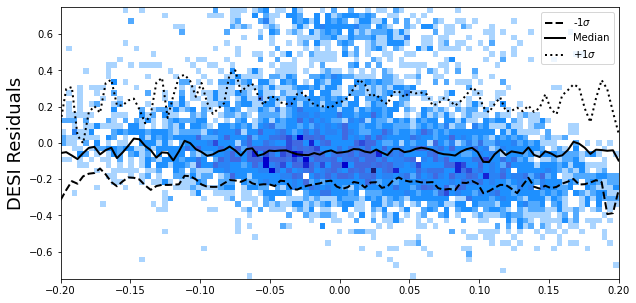

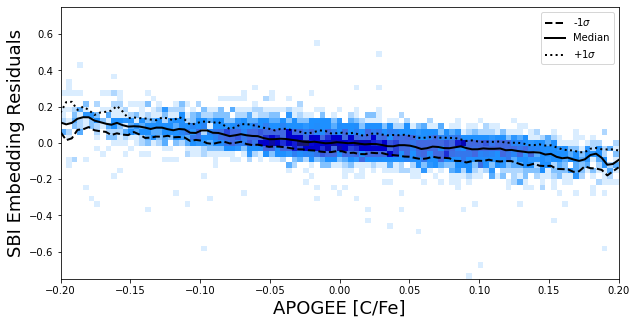

In [48]:
xbin = np.linspace(-0.2, 0.2, 100)
lower = [] # -1 sigma
median = []
upper = [] # +1 sigma
center = []
for n in range(len(xbin)-1):
    edges = [i for i in range(len(cfe_exp)) if (cfe_exp[i] >= xbin[n] and cfe_exp[i] < xbin[n+1])]
    residual = [] 
    if edges:
        c = (xbin[n + 1] + xbin[n]) / 2 # find the center of the bins where I'll put my points 
        center.append(c)
        for k in edges:
            residual.append(r3[k]) # append all the residuals 
        p = np.percentile(residual, (16, 50, 84)) # find where +-1 sigma and median are
        lower.append(p[0])
        median.append(p[1])
        upper.append(p[2])


# Interpolate values so we can plot lines on our 2D histogram
l = np.interp(xbin, center, lower) 
m = np.interp(xbin, center, median)
u = np.interp(xbin, center, upper)


desi_c = np.array(sp_tab_masked['C_FE_sp'])
xbin1 = np.linspace(-0.2, 0.2, 100)
r_desi = np.array(desi_c) - np.array(cfe_target)

lower1 = []
median1 = []
upper1 = []
center1 = []
for n in range(len(xbin1)-1):
    edges = [i for i in range(len(cfe_exp)) if (cfe_exp[i] >= xbin1[n] and cfe_exp[i]< xbin1[n+1])]
    residual = []
    if edges:
        c = (xbin1[n+1] + xbin1[n])/2
        center1.append(c)
        for k in edges:
            residual.append(r_desi[k])
        p = np.percentile(residual, (16, 50, 84))
        lower1.append(p[0])
        median1.append(p[1])
        upper1.append(p[2])


l1 = np.interp(xbin1, center1, lower1)
m1 = np.interp(xbin1, center1, median1)
u1 = np.interp(xbin1, center1, upper1)

# Plot the 2D histograms! 
plt.figure(figsize=(10, 5))
plt.hist2d(cfe_target, r_desi, bins = (np.linspace(-0.2, 0.2, 100), np.linspace(-0.75, 0.75, 50)), 
                         cmap = cmap)
plt.plot(xbin1, l1, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin1, m1, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin1, u1, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.ylabel('DESI Residuals', fontsize = 18)
# Add legend
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(10, 5))
plt.hist2d(cfe_exp, r3, bins = (np.linspace(-0.2, 0.2, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin, l, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin, m, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin, u, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.xlabel('APOGEE [C/Fe]', fontsize = 18)
plt.ylabel('SBI Embedding Residuals', fontsize = 18)
# Add legend
plt.legend()

# Show the plot
plt.show()

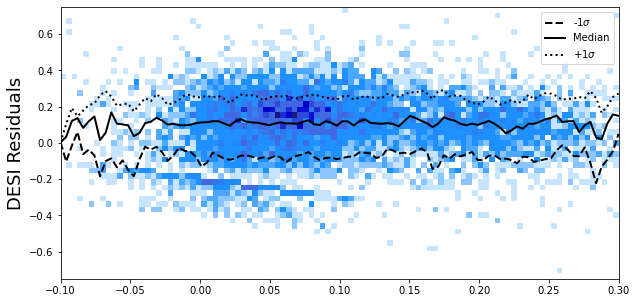

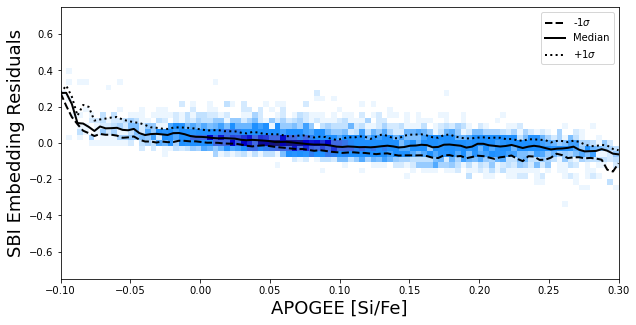

In [49]:
xbin = np.linspace(-0.1, 0.3, 100)
lower = [] # -1 sigma
median = []
upper = [] # +1 sigma
center = []
for n in range(len(xbin)-1):
    edges = [i for i in range(len(sife_exp)) if (sife_exp[i] >= xbin[n] and sife_exp[i] < xbin[n+1])]
    residual = [] 
    if edges:
        c = (xbin[n + 1] + xbin[n]) / 2 # find the center of the bins where I'll put my points 
        center.append(c)
        for k in edges:
            residual.append(r6[k]) # append all the residuals 
        p = np.percentile(residual, (16, 50, 84)) # find where +-1 sigma and median are
        lower.append(p[0])
        median.append(p[1])
        upper.append(p[2])


# Interpolate values so we can plot lines on our 2D histogram
l = np.interp(xbin, center, lower) 
m = np.interp(xbin, center, median)
u = np.interp(xbin, center, upper)


desi_si = np.array(sp_tab_masked['Si_FE_sp'])
xbin1 = np.linspace(-0.1, 0.3, 100)
r_desi = np.array(desi_si) - np.array(sife_target)

lower1 = []
median1 = []
upper1 = []
center1 = []
for n in range(len(xbin1)-1):
    edges = [i for i in range(len(sife_exp)) if (sife_exp[i] >= xbin1[n] and sife_exp[i]< xbin1[n+1])]
    residual = []
    if edges:
        c = (xbin1[n+1] + xbin1[n])/2
        center1.append(c)
        for k in edges:
            residual.append(r_desi[k])
        p = np.percentile(residual, (16, 50, 84))
        lower1.append(p[0])
        median1.append(p[1])
        upper1.append(p[2])


l1 = np.interp(xbin1, center1, lower1)
m1 = np.interp(xbin1, center1, median1)
u1 = np.interp(xbin1, center1, upper1)

# Plot the 2D histograms! 
plt.figure(figsize=(10, 5))
plt.hist2d(sife_target, r_desi, bins = (np.linspace(-0.1, 0.3, 100), np.linspace(-0.75, 0.75, 50)), 
                         cmap = cmap)
plt.plot(xbin1, l1, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin1, m1, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin1, u1, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.ylabel('DESI Residuals', fontsize = 18)
# Add legend
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(10, 5))

plt.hist2d(sife_exp, r6, bins = (np.linspace(-0.1, 0.3, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin, l, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin, m, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin, u, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.xlabel('APOGEE [Si/Fe]', fontsize = 18)
plt.ylabel('SBI Embedding Residuals', fontsize = 18)

# Add legend
plt.legend()

# Show the plot
plt.show()

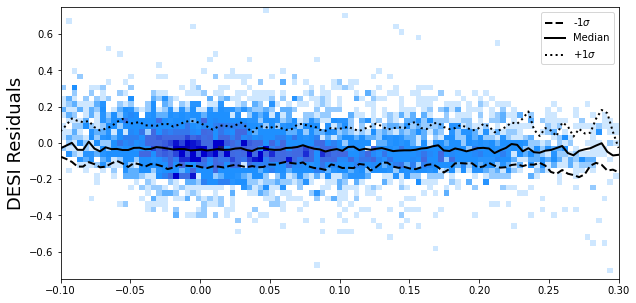

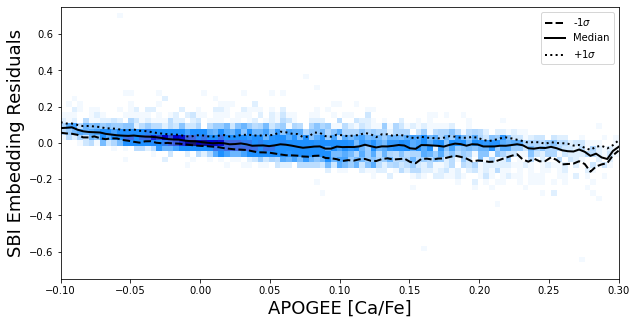

In [50]:
xbin = np.linspace(-0.1, 0.3, 100)
lower = [] # -1 sigma
median = []
upper = [] # +1 sigma
center = []
for n in range(len(xbin)-1):
    edges = [i for i in range(len(cafe_exp)) if (cafe_exp[i] >= xbin[n] and cafe_exp[i] < xbin[n+1])]
    residual = [] 
    if edges:
        c = (xbin[n + 1] + xbin[n]) / 2 # find the center of the bins where I'll put my points 
        center.append(c)
        for k in edges:
            residual.append(r8[k]) # append all the residuals 
        p = np.percentile(residual, (16, 50, 84)) # find where +-1 sigma and median are
        lower.append(p[0])
        median.append(p[1])
        upper.append(p[2])


# Interpolate values so we can plot lines on our 2D histogram
l = np.interp(xbin, center, lower) 
m = np.interp(xbin, center, median)
u = np.interp(xbin, center, upper)


desi_ca = np.array(sp_tab_masked['Ca_FE_sp'])
xbin1 = np.linspace(-0.1, 0.3, 100)
r_desi = np.array(desi_ca) - np.array(cafe_target)

lower1 = []
median1 = []
upper1 = []
center1 = []
for n in range(len(xbin1)-1):
    edges = [i for i in range(len(cafe_exp)) if (cafe_exp[i] >= xbin1[n] and cafe_exp[i]< xbin1[n+1])]
    residual = []
    if edges:
        c = (xbin1[n+1] + xbin1[n])/2
        center1.append(c)
        for k in edges:
            residual.append(r_desi[k])
        p = np.percentile(residual, (16, 50, 84))
        lower1.append(p[0])
        median1.append(p[1])
        upper1.append(p[2])


l1 = np.interp(xbin1, center1, lower1)
m1 = np.interp(xbin1, center1, median1)
u1 = np.interp(xbin1, center1, upper1)

# Plot the 2D histograms! 
plt.figure(figsize=(10, 5))
plt.hist2d(cafe_target, r_desi, bins = (np.linspace(-0.1, 0.3, 100), np.linspace(-0.75, 0.75, 50)), 
                         cmap = cmap)
plt.plot(xbin1, l1, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin1, m1, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin1, u1, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)


plt.ylabel('DESI Residuals', fontsize = 18)
# Add legend
plt.legend()

# Show the plot
plt.show()
plt.figure(figsize=(10, 5))
plt.hist2d(cafe_exp, r8, bins = (np.linspace(-0.1, 0.3, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin, l, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin, m, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin, u, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.xlabel('APOGEE [Ca/Fe]', fontsize = 18)
plt.ylabel('SBI Embedding Residuals', fontsize = 18)

# Add legend
plt.legend()

# Show the plot
plt.show()

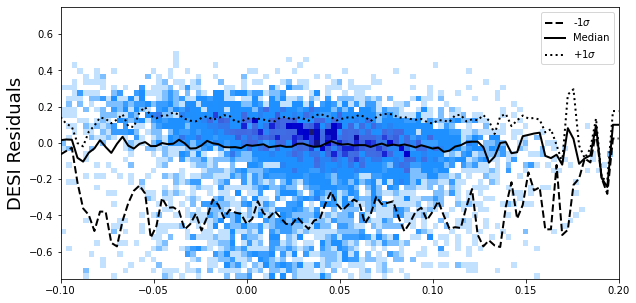

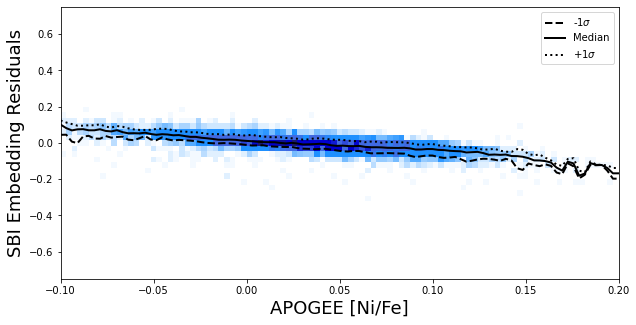

In [51]:
xbin = np.linspace(-0.1, 0.2, 100)
lower = [] # -1 sigma
median = []
upper = [] # +1 sigma
center = []
for n in range(len(xbin)-1):
    edges = [i for i in range(len(nife_exp)) if (nife_exp[i] >= xbin[n] and nife_exp[i] < xbin[n+1])]
    residual = [] 
    if edges:
        c = (xbin[n + 1] + xbin[n]) / 2 # find the center of the bins where I'll put my points 
        center.append(c)
        for k in edges:
            residual.append(r10[k]) # append all the residuals 
        p = np.percentile(residual, (16, 50, 84)) # find where +-1 sigma and median are
        lower.append(p[0])
        median.append(p[1])
        upper.append(p[2])


# Interpolate values so we can plot lines on our 2D histogram
l = np.interp(xbin, center, lower) 
m = np.interp(xbin, center, median)
u = np.interp(xbin, center, upper)


desi_ni = np.array(sp_tab_masked['Ni_FE_sp'])
xbin1 = np.linspace(-0.1, 0.2, 100)
r_desi = np.array(desi_ni) - np.array(nife_target)

lower1 = []
median1 = []
upper1 = []
center1 = []
for n in range(len(xbin1)-1):
    edges = [i for i in range(len(nife_exp)) if (nife_exp[i] >= xbin1[n] and nife_exp[i]< xbin1[n+1])]
    residual = []
    if edges:
        c = (xbin1[n+1] + xbin1[n])/2
        center1.append(c)
        for k in edges:
            residual.append(r_desi[k])
        p = np.percentile(residual, (16, 50, 84))
        lower1.append(p[0])
        median1.append(p[1])
        upper1.append(p[2])


l1 = np.interp(xbin1, center1, lower1)
m1 = np.interp(xbin1, center1, median1)
u1 = np.interp(xbin1, center1, upper1)

# Plot the 2D histograms! 
plt.figure(figsize=(10, 5))
plt.hist2d(nife_target, r_desi, bins = (np.linspace(-0.1, 0.2, 100), np.linspace(-0.75, 0.75, 50)), 
                         cmap = cmap)
plt.plot(xbin1, l1, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin1, m1, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin1, u1, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.ylabel('DESI Residuals', fontsize = 18)
# Add legend
plt.legend()

plt.figure(figsize=(10, 5))
plt.hist2d(nife_exp, r10, bins = (np.linspace(-0.1, 0.2, 100), np.linspace(-0.75, 0.75, 50)), cmap = cmap)
plt.plot(xbin, l, c = 'black', linestyle = '--', label = '-1$\sigma$', lw = 2)
plt.plot(xbin, m, c = 'black', label = 'Median', lw = 2)
plt.plot(xbin, u, c = 'black', linestyle = 'dotted', label = '+1$\sigma$', lw = 2)

plt.xlabel('APOGEE [Ni/Fe]', fontsize = 18)
plt.ylabel('SBI Embedding Residuals', fontsize = 18)

# Add legend
plt.legend()

# Show the plot
plt.show()

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

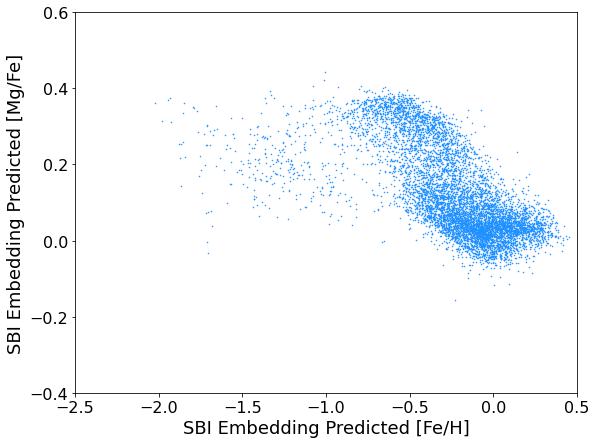

In [52]:
# Plot Model Predict [Mg/Fe] vs. [Fe/H]
plt.figure(figsize = (9, 7))
# fix x axis range: [-2.5, 0.5], fix y axis range [-0.4, 0.6]
plt.xlim(-2.5, 0.5)
plt.ylim(-0.4, 0.6)
plt.scatter(feh_pred, mgfe_pred, s = 0.3, c = 'dodgerblue') 
plt.xlabel('SBI Embedding Predicted [Fe/H]', fontsize = 18)
plt.ylabel('SBI Embedding Predicted [Mg/Fe]', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

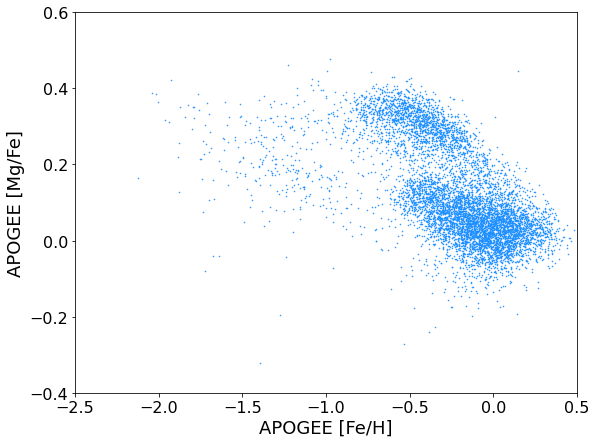

In [53]:
# APOGEE [Mg/Fe] vs. [Fe/H]
plt.figure(figsize = (9, 7))
# fix x axis range: [-2.5, 0.5], fix y axis range [-0.4, 0.6]
plt.xlim(-2.5, 0.5)
plt.ylim(-0.4, 0.6)
plt.scatter(feh_target, mgfe_target, s = 0.3, c = 'dodgerblue') 
plt.xlabel('APOGEE [Fe/H]', fontsize = 18)
plt.ylabel('APOGEE [Mg/Fe]', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

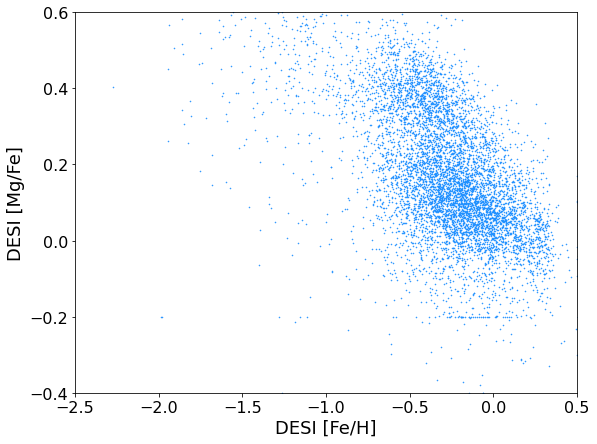

In [54]:
# DESI [Mg/Fe] vs. [Fe/H]
plt.figure(figsize = (9, 7))
# fix x axis range: [-2.5, 0.5], fix y axis range [-0.4, 0.6]
plt.xlim(-2.5, 0.5)
plt.ylim(-0.4, 0.6)
#feh_desi = np.array(subset_matches['FEH_1'])
feh_desi = np.array(sp_tab_masked['Fe_H_sp'])
mgfe_desi = np.array(sp_tab_masked['Mg_FE_sp'])
plt.scatter(feh_desi, mgfe_desi, s = 0.3, c = 'dodgerblue') 
plt.xlabel('DESI [Fe/H]', fontsize = 18)
plt.ylabel('DESI [Mg/Fe]', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

In [ ]:
# Substructure Predictions

In [55]:
np.random.seed(20230921)
X_Sequoia = torch.Tensor(X_Sequoia)
X_Antaeus = torch.Tensor(X_Antaeus)
X_ED2 = torch.Tensor(X_ED2)
X_IoM2 = torch.Tensor(X_IoM2)
X_H99 = torch.Tensor(X_H99)

In [56]:
feh_pred_H99 = []
feh_var_H99 = []
mgfe_pred_H99 = []
mgfe_var_H99 = []
ofe_pred_H99 = []
ofe_var_H99 = []
cfe_pred_H99 = []
cfe_var_H99 = []
cife_pred_H99 = []
cife_var_H99 = []
sife_pred_H99 = []
sife_var_H99 = []
kfe_pred_H99 = []
kfe_var_H99 = []
cafe_pred_H99 = []
cafe_var_H99 = []
mnfe_pred_H99 = []
mnfe_var_H99 = []
nife_pred_H99 = []
nife_var_H99 = []
log_g_pred_H99 = []
log_g_var_H99 = []
teff_pred_H99 = []
teff_var_H99 = []


scaler = StandardScaler()
scaler.fit(X_H99)
X = scaler.transform(X_H99)
X_test = torch.Tensor(X)


n_samples = 250

for idx in range(len(X_test)):
    samples = posterior.sample((n_samples,), x=X_test[idx])
    fe_h = samples[:, 0]
    mg_fe = samples[:, 1]
    o_fe = samples[:, 2]
    c_fe = samples[:, 3]
    ci_fe = samples[:, 4]
    si_fe = samples[:, 5]
    k_fe = samples[:, 6]
    ca_fe = samples[:, 7]
    mn_fe = samples[:, 8]
    ni_fe = samples[:, 9]
    log_g = samples[:, 10]
    teff = samples[:, 11]
        
    feh_pred_H99.append(torch.mean(fe_h))
    feh_var_H99.append(torch.var(fe_h))
    mgfe_pred_H99.append(torch.mean(mg_fe))
    mgfe_var_H99.append(torch.var(mg_fe))
    ofe_pred_H99.append(torch.mean(o_fe))
    ofe_var_H99.append(torch.var(o_fe))
    cfe_pred_H99.append(torch.mean(c_fe))
    cfe_var_H99.append(torch.var(c_fe))
    cife_pred_H99.append(torch.mean(ci_fe))
    cife_var_H99.append(torch.var(ci_fe))
    sife_pred_H99.append(torch.mean(si_fe))
    sife_var_H99.append(torch.var(si_fe))
    kfe_pred_H99.append(torch.mean(k_fe))
    kfe_var_H99.append(torch.var(k_fe))
    cafe_pred_H99.append(torch.mean(ca_fe))
    cafe_var_H99.append(torch.var(ca_fe))
    mnfe_pred_H99.append(torch.mean(mn_fe))
    mnfe_var_H99.append(torch.var(mn_fe))
    nife_pred_H99.append(torch.mean(ni_fe))
    nife_var_H99.append(torch.var(ni_fe))
    log_g_pred_H99.append(torch.mean(log_g))
    log_g_var_H99.append(torch.var(log_g))
    teff_pred_H99.append(torch.mean(teff))
    teff_var_H99.append(torch.var(teff))

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15594.76it/s]


In [57]:
import torch
import torch.nn as nn 
from sklearn.preprocessing import StandardScaler

feh_pred_ED2 = []

mgfe_pred_ED2 = []
ofe_pred_ED2 = []
cfe_pred_ED2 = []
cife_pred_ED2 = []
sife_pred_ED2 = []
kfe_pred_ED2 = []
cafe_pred_ED2 = []
mnfe_pred_ED2 = []
nife_pred_ED2 = []


feh_var_ED2 = []
mgfe_var_ED2 = []


scaler = StandardScaler()
scaler.fit(X_ED2)
X = scaler.transform(X_ED2)
X_test = torch.Tensor(X)


n_samples = 250

for idx in range(len(X_test)):
    samples = posterior.sample((n_samples,), x=X_test[idx])
    fe_h = samples[:, 0]
    mg_fe = samples[:, 1]
    o_fe = samples[:, 2]
    c_fe = samples[:, 3]
    ci_fe = samples[:, 4]
    si_fe = samples[:, 5]
    k_fe = samples[:, 6]
    ca_fe = samples[:, 7]
    mn_fe = samples[:, 8]
    ni_fe = samples[:, 9]
        
    feh_pred_ED2.append(torch.mean(fe_h))
    feh_var_ED2.append(torch.var(fe_h))
    mgfe_pred_ED2.append(torch.mean(mg_fe))
    mgfe_var_ED2.append(torch.var(mg_fe))
    
    ofe_pred_ED2.append(torch.mean(o_fe))
    cfe_pred_ED2.append(torch.mean(c_fe))
    cife_pred_ED2.append(torch.mean(ci_fe))
    sife_pred_ED2.append(torch.mean(si_fe))
    kfe_pred_ED2.append(torch.mean(k_fe))
    cafe_pred_ED2.append(torch.mean(ca_fe))
    mnfe_pred_ED2.append(torch.mean(mn_fe))
    nife_pred_ED2.append(torch.mean(ni_fe))

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15485.59it/s]


In [58]:
import torch
import torch.nn as nn 
from sklearn.preprocessing import StandardScaler

feh_pred_IoM2 = []
mgfe_pred_IoM2 = []
ofe_pred_IoM2 = []
cfe_pred_IoM2 = []
cife_pred_IoM2 = []
sife_pred_IoM2 = []
kfe_pred_IoM2 = []
cafe_pred_IoM2 = []
mnfe_pred_IoM2 = []
nife_pred_IoM2 = []


feh_var_IoM2 = []
mgfe_var_IoM2 = []

scaler = StandardScaler()
scaler.fit(X_IoM2)
X = scaler.transform(X_IoM2)
X_test = torch.Tensor(X)


n_samples = 250

for idx in range(len(X_test)):
    samples = posterior.sample((n_samples,), x=X_test[idx])
    fe_h = samples[:, 0]
    mg_fe = samples[:, 1]
    o_fe = samples[:, 2]
    c_fe = samples[:, 3]
    ci_fe = samples[:, 4]
    si_fe = samples[:, 5]
    k_fe = samples[:, 6]
    ca_fe = samples[:, 7]
    mn_fe = samples[:, 8]
    ni_fe = samples[:, 9]
        
    feh_pred_IoM2.append(torch.mean(fe_h))
    feh_var_IoM2.append(torch.var(fe_h))
    
    mgfe_pred_IoM2.append(torch.mean(mg_fe))
    mgfe_var_IoM2.append(torch.var(mg_fe))
    
    ofe_pred_IoM2.append(torch.mean(o_fe))
    cfe_pred_IoM2.append(torch.mean(c_fe))
    cife_pred_IoM2.append(torch.mean(ci_fe))
    sife_pred_IoM2.append(torch.mean(si_fe))
    kfe_pred_IoM2.append(torch.mean(k_fe))
    cafe_pred_IoM2.append(torch.mean(ca_fe))
    mnfe_pred_IoM2.append(torch.mean(mn_fe))
    nife_pred_IoM2.append(torch.mean(ni_fe))

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15714.65it/s]


In [59]:
import torch
import torch.nn as nn 
from sklearn.preprocessing import StandardScaler

feh_pred_Antaeus = []
mgfe_pred_Antaeus = []
ofe_pred_Antaeus = []
cfe_pred_Antaeus = []
cife_pred_Antaeus = []
sife_pred_Antaeus = []
kfe_pred_Antaeus = []
cafe_pred_Antaeus = []
mnfe_pred_Antaeus = []
nife_pred_Antaeus = []

feh_var_Antaeus = []
mgfe_var_Antaeus = []
 

scaler = StandardScaler()
scaler.fit(X_Antaeus)
X = scaler.transform(X_Antaeus)
X_test = torch.Tensor(X)


n_samples = 250

for idx in range(len(X_test)):
    samples = posterior.sample((n_samples,), x=X_test[idx])
    fe_h = samples[:, 0]
    mg_fe = samples[:, 1]
    o_fe = samples[:, 2]
    c_fe = samples[:, 3]
    ci_fe = samples[:, 4]
    si_fe = samples[:, 5]
    k_fe = samples[:, 6]
    ca_fe = samples[:, 7]
    mn_fe = samples[:, 8]
    ni_fe = samples[:, 9]
        
    feh_pred_Antaeus.append(torch.mean(fe_h))
    feh_var_Antaeus.append(torch.var(fe_h))
    
    mgfe_pred_Antaeus.append(torch.mean(mg_fe))
    mgfe_var_Antaeus.append(torch.var(mg_fe))
    
    ofe_pred_Antaeus.append(torch.mean(o_fe))
    cfe_pred_Antaeus.append(torch.mean(c_fe))
    cife_pred_Antaeus.append(torch.mean(ci_fe))
    sife_pred_Antaeus.append(torch.mean(si_fe))
    kfe_pred_Antaeus.append(torch.mean(k_fe))
    cafe_pred_Antaeus.append(torch.mean(ca_fe))
    mnfe_pred_Antaeus.append(torch.mean(mn_fe))
    nife_pred_Antaeus.append(torch.mean(ni_fe))

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15622.64it/s]


In [60]:
feh_pred_Sequoia = []
mgfe_pred_Sequoia = []
ofe_pred_Sequoia = []
cfe_pred_Sequoia = []
cife_pred_Sequoia = []
sife_pred_Sequoia = []
kfe_pred_Sequoia = []
cafe_pred_Sequoia = []
mnfe_pred_Sequoia = []
nife_pred_Sequoia = []

feh_var_Sequoia = []
mgfe_var_Sequoia = []

scaler = StandardScaler()
scaler.fit(X_Sequoia)
X = scaler.transform(X_Sequoia)
X_test = torch.Tensor(X)


n_samples = 250

for idx in range(len(X_test)):
    samples = posterior.sample((n_samples,), x=X_test[idx])
    fe_h = samples[:, 0]
    mg_fe = samples[:, 1]
    o_fe = samples[:, 2]
    c_fe = samples[:, 3]
    ci_fe = samples[:, 4]
    si_fe = samples[:, 5]
    k_fe = samples[:, 6]
    ca_fe = samples[:, 7]
    mn_fe = samples[:, 8]
    ni_fe = samples[:, 9]
        
    feh_pred_Sequoia.append(torch.mean(fe_h))
    feh_var_Sequoia.append(torch.var(fe_h))
    
    mgfe_pred_Sequoia.append(torch.mean(mg_fe))
    mgfe_var_Sequoia.append(torch.var(mg_fe))   
    
    ofe_pred_Sequoia.append(torch.mean(o_fe))
    cfe_pred_Sequoia.append(torch.mean(c_fe))
    cife_pred_Sequoia.append(torch.mean(ci_fe))
    sife_pred_Sequoia.append(torch.mean(si_fe))
    kfe_pred_Sequoia.append(torch.mean(k_fe))
    cafe_pred_Sequoia.append(torch.mean(ca_fe))
    mnfe_pred_Sequoia.append(torch.mean(mn_fe))
    nife_pred_Sequoia.append(torch.mean(ni_fe))

Drawing 250 posterior samples: 100%|██████████| 250/250 [00:00<00:00, 15538.14it/s]


In [61]:
cmap = colours.LinearSegmentedColormap.from_list('greenblue', ['white', 'dodgerblue', 'dodgerblue', 'royalblue', 
                                                               'royalblue', 'mediumblue', 'mediumblue', 
                                                               'midnightblue'])

In [62]:
feh_pred_H99 = torch.stack(feh_pred_H99)
mgfe_pred_H99 = torch.stack(mgfe_pred_H99)
cfe_pred_H99 = torch.stack(cfe_pred_H99)
cife_pred_H99 = torch.stack(cife_pred_H99)
sife_pred_H99 = torch.stack(sife_pred_H99)
cafe_pred_H99 = torch.stack(cafe_pred_H99)
kfe_pred_H99 = torch.stack(kfe_pred_H99)
nife_pred_H99 = torch.stack(nife_pred_H99)

In [63]:
feh_var_H99 = torch.stack(feh_var_H99)
feh_var_ED2 = torch.stack(feh_var_ED2)
feh_var_IoM2 = torch.stack(feh_var_IoM2)
feh_var_Antaeus = torch.stack(feh_var_Antaeus)
feh_var_Sequoia = torch.stack(feh_var_Sequoia)

In [64]:
mgfe_var_H99 = torch.stack(mgfe_var_H99)

In [65]:
mnfe_pred_H99 = torch.stack(mnfe_pred_H99)
mnfe_pred_ED2 = torch.stack(mnfe_pred_ED2)
mnfe_pred_IoM2 = torch.stack(mnfe_pred_IoM2)
mnfe_pred_Antaeus = torch.stack(mnfe_pred_Antaeus)
mnfe_pred_Sequoia = torch.stack(mnfe_pred_Sequoia)

In [66]:
feh_pred_ED2 = torch.stack(feh_pred_ED2)
mgfe_pred_ED2 = torch.stack(mgfe_pred_ED2)
cfe_pred_ED2 = torch.stack(cfe_pred_ED2)
cife_pred_ED2 = torch.stack(cife_pred_ED2)
sife_pred_ED2 = torch.stack(sife_pred_ED2)
cafe_pred_ED2 = torch.stack(cafe_pred_ED2)
kfe_pred_ED2 = torch.stack(kfe_pred_ED2)
nife_pred_ED2 = torch.stack(nife_pred_ED2)

In [67]:
feh_pred_IoM2 = torch.stack(feh_pred_IoM2)
mgfe_pred_IoM2 = torch.stack(mgfe_pred_IoM2)
cfe_pred_IoM2 = torch.stack(cfe_pred_IoM2)
cife_pred_IoM2 = torch.stack(cife_pred_IoM2)
sife_pred_IoM2 = torch.stack(sife_pred_IoM2)
cafe_pred_IoM2 = torch.stack(cafe_pred_IoM2)
kfe_pred_IoM2 = torch.stack(kfe_pred_IoM2)
nife_pred_IoM2 = torch.stack(nife_pred_IoM2)

In [68]:
feh_pred_Antaeus = torch.stack(feh_pred_Antaeus)
mgfe_pred_Antaeus = torch.stack(mgfe_pred_Antaeus)
cfe_pred_Antaeus = torch.stack(cfe_pred_Antaeus)
cife_pred_Antaeus = torch.stack(cife_pred_Antaeus)
sife_pred_Antaeus = torch.stack(sife_pred_Antaeus)
cafe_pred_Antaeus = torch.stack(cafe_pred_Antaeus)
kfe_pred_Antaeus = torch.stack(kfe_pred_Antaeus)
nife_pred_Antaeus = torch.stack(nife_pred_Antaeus)

In [69]:
feh_pred_Sequoia = torch.stack(feh_pred_Sequoia)
mgfe_pred_Sequoia = torch.stack(mgfe_pred_Sequoia)
cfe_pred_Sequoia = torch.stack(cfe_pred_Sequoia)
cife_pred_Sequoia = torch.stack(cife_pred_Sequoia)
sife_pred_Sequoia = torch.stack(sife_pred_Sequoia)
cafe_pred_Sequoia = torch.stack(cafe_pred_Sequoia)
kfe_pred_Sequoia = torch.stack(kfe_pred_Sequoia)
nife_pred_Sequoia = torch.stack(nife_pred_Sequoia)

In [70]:
feh_std_H99 = np.sqrt(feh_var_H99)
feh_std_ED2 = np.sqrt(feh_var_ED2)
feh_std_IoM2 = np.sqrt(feh_var_IoM2)
feh_std_Antaeus = np.sqrt(feh_var_Antaeus)
feh_std_Sequoia = np.sqrt(feh_var_Sequoia)
mgfe_std_H99 = np.sqrt(mgfe_var_H99)

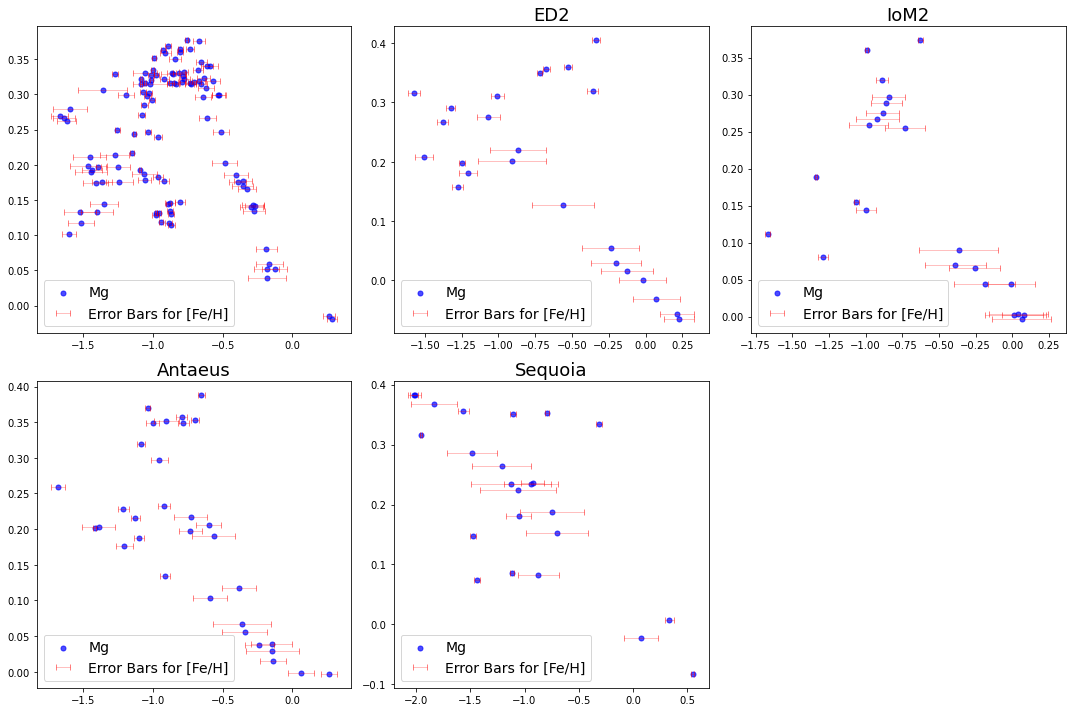

In [71]:
import matplotlib.pyplot as plt

# how to add error bars (std) to the plot if I know feh_var_H99 and mgfe_var_H99?

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot for H99
scatter_plot_H99 = axes[0, 0].scatter(
    feh_pred_H99,
    mgfe_pred_H99,
    s=25,       # Marker size
    c='blue',
    label='Mg',
    alpha=0.7
)

# Error bars for H99 using standard deviations
errorbars_H99 = axes[0, 0].errorbar(
    feh_pred_H99,
    mgfe_pred_H99,
    xerr=feh_std_H99,
    #yerr=mgfe_std_H99,
    fmt='none',    # Marker style
    markersize=2,   # Marker size
    color='red',   # Color of error bars
    alpha=0.5,
    elinewidth=0.5,   # Line width of error bars
    capsize = 3
)

legend_labels_H99 = ['Mg', 'Error Bars for [Fe/H]']
axes[0, 0].legend([scatter_plot_H99, errorbars_H99], legend_labels_H99, fontsize=14)
axes[0, 1].set_title('H99', fontsize=18)


scatter_plot_ED2 = axes[0, 1].scatter(
    feh_pred_ED2,
    mgfe_pred_ED2,
    s=25,       # Marker size
    c='blue',
    label='Mg',
    alpha=0.7
)


errorbars_ED2 = axes[0, 1].errorbar(
    feh_pred_ED2,
    mgfe_pred_ED2,
    xerr=feh_std_ED2,
    #yerr=mgfe_std_H99,
    fmt='none',    # Marker style
    markersize=2,   # Marker size
    color='red',   # Color of error bars
    alpha=0.5,
    elinewidth=0.5,  # Line width of error bars
    capsize = 3
)

legend_labels_ED2 = ['Mg', 'Error Bars for [Fe/H]']
axes[0, 1].legend([scatter_plot_ED2, errorbars_ED2], legend_labels_ED2, fontsize=14)
axes[0, 1].set_title('ED2', fontsize=18)


scatter_plot_IoM2 = axes[0, 2].scatter(
    feh_pred_IoM2,
    mgfe_pred_IoM2,
    s=25,       # Marker size
    c='blue',
    label='Mg',
    alpha=0.7
)

errorbars_IoM2 = axes[0, 2].errorbar(
    feh_pred_IoM2,
    mgfe_pred_IoM2,
    xerr=feh_std_IoM2,
    #yerr=mgfe_std_H99,
    fmt='none',    # Marker style
    markersize=2,   # Marker size
    color='red',   # Color of error bars
    alpha=0.5,
    elinewidth=0.5,  # Line width of error bars
    capsize = 3
)

legend_labels_IoM2 = ['Mg', 'Error Bars for [Fe/H]']
axes[0, 2].legend([scatter_plot_IoM2, errorbars_IoM2], legend_labels_IoM2, fontsize=14)
axes[0, 2].set_title('IoM2', fontsize=18)


scatter_plot_Antaeus = axes[1, 0].scatter(
    feh_pred_Antaeus,
    mgfe_pred_Antaeus,
    s=25,       # Marker size
    c='blue',
    label='Mg',
    alpha=0.7
)

errorbars_Antaeus = axes[1, 0].errorbar(
    feh_pred_Antaeus,
    mgfe_pred_Antaeus,
    xerr=feh_std_Antaeus,
    #yerr=mgfe_std_H99,
    fmt='none',    # Marker style
    markersize=2,   # Marker size
    color='red',   # Color of error bars
    alpha=0.5,
    elinewidth=0.5,   # Line width of error bars
    capsize = 3
)

legend_labels_Antaeus = ['Mg', 'Error Bars for [Fe/H]']
axes[1, 0].legend([scatter_plot_Antaeus, errorbars_Antaeus], legend_labels_Antaeus, fontsize=14)
axes[1, 0].set_title('Antaeus', fontsize=18)



scatter_plot_Sequoia = axes[1, 1].scatter(
    feh_pred_Sequoia,
    mgfe_pred_Sequoia,
    s=25,       # Marker size
    c='blue',
    label='Mg',
    alpha=0.7
)

errorbars_Sequoia = axes[1, 1].errorbar(
    feh_pred_Sequoia,
    mgfe_pred_Sequoia,
    xerr=feh_std_Sequoia,
    #yerr=mgfe_std_H99,
    fmt='none',    # Marker style
    markersize=2,   # Marker size
    color='red',   # Color of error bars
    alpha=0.5,
    elinewidth=0.5,   # Line width of error bars
    capsize = 3
)

legend_labels_Sequoia = ['Mg', 'Error Bars for [Fe/H]']
axes[1, 1].legend([scatter_plot_Sequoia, errorbars_Sequoia], legend_labels_Sequoia, fontsize=14)
axes[1, 1].set_title('Sequoia', fontsize=18)

# Hide the empty subplot in the last column
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()